# Capstone projet by Louis Cavaleri 

# Fossil classifier

## Introduction
The goal of this project is to develop a system that can accurately identify, classify and recognise fossil images like dinosaurs or trace fossils.

Identifying fossils can be a time-consuming process that relies on expert knowledge of fossil morphology. Fossils can be challenging to identify due to their fragmented and degraded nature.

The main problem to address in this project is the development of a machine learning model capable of accurately recognising and classifying fossils based on their images.


##  The data


### Overview of your data


- Source and context of the dataset: The dataset is a collection of fossil images obtained by using a web crawler to download fossil images from the Internet and automatically export the data into a structured dataset.
    - __reduced-FID__ dataset: I will use the reduced-FID with 60 thousand images and 50 category of fossils publish by <a href="https://zenodo.org/record/6333970">zenodo.org </a>. Links to download the [reduced-FID dataset](https://zenodo.org/record/6333970/files/reduced-FID.zip?download=1)
    - __FID__ dataset: This dataset is used to fill the gaps of the reduced-FID. Links to download the <a href="https://zenodo.org/record/6333970/files/FID.zip?download=1">FID dataset</a>. 
    - __fossil-vs-non-fossil__ dataset, I used to remove irrelevant images. [fossil-vs-non-fossil.zip](https://drive.google.com/file/d/1PDpBdpD7_4jHZIcRFQBYatoU4Jy9Dhj1/view?usp=sharing) <br><br>


- Samples of the entries, features, values: The dataset is a reduced version of the Fossil Image Dataset that contains 415 thousand images.

- Number of features and samples: The dataset contains 60 thousand RGB images 1200~ image for each 50 category of fossils.

- Encoding of the features: The images are stored in subfolder with each subfolder named according to the commune ancestor. 

- Quality of the data: the data is of high quality, with no missing images. However some images are not relevant or have some obstruction like text or humans.

- Images format: the images have the following format BMP, GIF, JPEG, PNG, TIFF.

- Below I will display a small sample of some images contained in the dataset. 

### agnatha
![Alt text](data/illustrate-image/agnatha_905.jpg)
### amphibian
![Alt text](data/illustrate-image/amphibian_1.jpg)
### theropod
![Alt text](data/illustrate-image/theropod_25.jpg)

### **Data exploration and cleaning**

#### **Managing the data**
- Extract ``zip`` into a non-compressed file name ``reduced-FID``

- Rename the images for easy access. 

- Verify image integrity: check for corrupted or unreadable images and remove them from the dataset.

- Remove duplicated images using <a href="https://pypi.org/project/ImageHash/">imagehash</a> (an algorithm that can distinguish if two images look nearly identical). 

- Change image format for ``'BMP' 'GIF' 'JPEG' 'PNG' 'TIFF'`` I will change them in  ``PNG`` for lossless compression format and ``JPEG`` for lossy compression. 


### **Dependencies to install**

>__imagehash__ is a package that needs to be installed on the environment: 
>- using conda: ``conda install -c conda-forge imagehash``
>- using pip: ``pip install ImageHash``


>__scikit-image 0.21.0__ is a package that needs to be installed on the environment: 
>- using pip: ``pip install scikit-image``

>__split-folders__ is a package that needs to be installed on the environment: 
>- using pip: ``pip install split-folders``

>__yellowbrick 1.5__ is a package that needs to be installed on the environment: 
>- using pip: ``pip install yellowbrick``


>**Note** <br>
For windows users, please use the python code below to prevent the error message ``Error 0x80010135 path too long``

### Let's begin by extracting the ``reduced-FID.zip`` file.

In [1]:
# Code to extract a zip
import zipfile

def extract_zip(zip_file_path, extract_path):
    with zipfile.ZipFile(zip_file_path, "r") as zipf:
        zipf.extractall(extract_path)


zip_file_path = "data/reduced-FID.zip"
extract_path = "data/reduced-FID"
extract_zip(zip_file_path, extract_path)

### Renaming my images using the folder name and their sample number.

In [2]:
# The path to the directory containing the subfolders
import os

dir_path = os.path.join("data", "reduced-FID", "reduced-FID")

In [3]:
# Code to rename images
import shutil

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):
    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop over all files in the subfolder
        for i, filename in enumerate(os.listdir(subfolder_path)):
            # Get the full path to the file
            file_path = os.path.join(subfolder_path, filename)

            # Check if the file is an image
            if os.path.isfile(file_path):
                # Get the file extension
                extension = os.path.splitext(filename)[1]

                # Generate the new file name
                new_filename = subfolder_name + '_' + str(i+1) + extension

                # Get the full path to the new file
                new_file_path = os.path.join(subfolder_path, new_filename)

                # Rename the file
                shutil.move(file_path, new_file_path) 

    """ print(f"folder {subfolder_name} is done") """

### Checking for duplicated images and images we can't open 

I'm using  ``phash`` the function from the ``ImageHash`` library in Python that computes a hash by following these steps:
- The image is resized to 32x32 to preserve more detail.
- The image is then converted to grayscale.
- A Discrete Cosine Transform (DCT) is applied. This allows the ``phash`` algorithm to capture elements that are perceived similarly by the human eye, hence the name "perceptual" hashing.
- From the DCT, only the top-left 8x8 pixels are kept. This is done to retain the dominant shapes, colors, and intensities that define an image at a high level.
- The median value of these 64 pixels is then computed. This is used as the threshold to convert these 64 pixels into a binary value (1 or 0) depending on whether the pixel's value is above or below the median.
- The binary values are concatenated to form the hash.

This algorithm is more computationally expensive than ``imagehash.average_hash``. However, ``phash`` is more robust to changes in image size, aspect ratio, and color.

When performing tests with different algorithms like ``imagehash.average_hash``, ``phash``, ``dhash``, and ``whash``, I found that fewer images were misclassified when using ``phash``.


For more information check this <a href="https://www.hackerfactor.com/blog/index.php?/archives/432-Looks-Like-It.html">article</a>.

In [4]:
import imagehash
from PIL import Image

# A dictionary to store the hashes of each image
hashes = {}
image_to_delete = []
duplicated_image = []
original_image = []

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):
    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop over all files in the subfolder
        for filename in os.listdir(subfolder_path):
            # Get the full path to the file
            file_path = os.path.join(subfolder_path, filename)

            # Check if the file is an image
            try:
                # Open the image
                with Image.open(file_path) as image:
                    # Calculate the hash of the image
                    hash = str(imagehash.phash(image))

                    # Check if the hash is already in the dictionary
                    if hash in hashes:
                        # If the hash is already in the dictionary, it means that the image is a duplicate
                        # Save duplicate file path 
                        duplicated_image.append(file_path)
                        # Save corresponding duplicate image (original image)
                        original_image.append(hashes[hash])
                    else:
                        # If the hash is not in the dictionary, add it to the dictionary
                        hashes[hash] = file_path

             # If we can't open the image we save in image_to_delete
            except:
                image_to_delete.append(file_path)

    """ print(f"folder {subfolder_name} is done") """


print(f"\nNumber of duplicate images:{len(duplicated_image)}")
print(f"Number of image we can't open:{len(image_to_delete)}")


Number of duplicate images:112
Number of image we can't open:10


We see 112 duplicate images and 10 that couldn't be open.

### Visualising some duplicated images

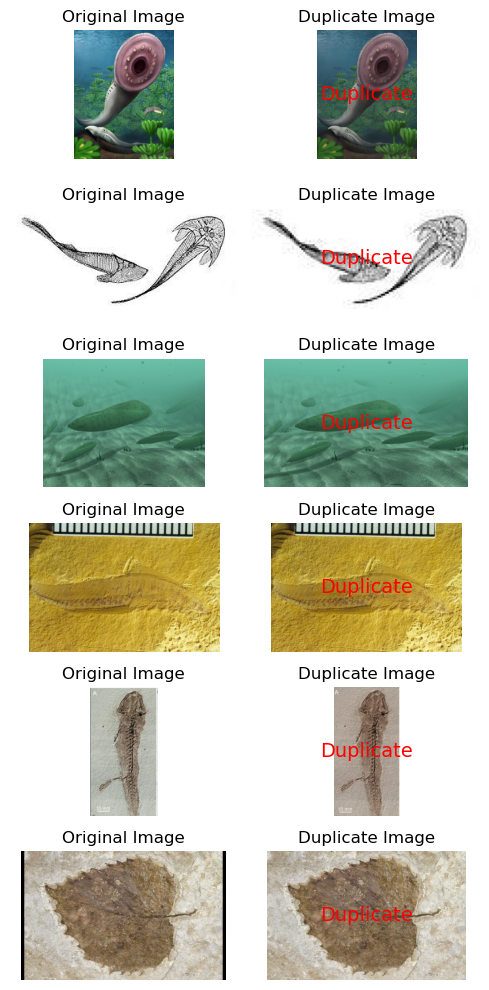

In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define a function to open a image
def open_img(path):
    with Image.open(path) as img:
        return np.array(img)


# Visualize the duplicate image pairs
number_of_image_to_display = 6

# Create a figure with two subplots
fig, axes = plt.subplots(number_of_image_to_display, 2, figsize=(5, 10))


for i, (duplicate_path, img_path) in enumerate(zip(duplicated_image[:number_of_image_to_display], original_image[:number_of_image_to_display])):
 
    # Open the image 
    original_img = open_img(img_path)
    duplicate_img = open_img(duplicate_path)

    axes[i, 0].imshow(original_img)
    axes[i, 0].set_title("Original Image")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(duplicate_img)
    axes[i, 1].set_title("Duplicate Image")
    axes[i, 1].axis("off")

    # Add a text label to indicate the duplicate relationship
    axes[i, 1].text(
        0.5, 0.5, "Duplicate",
        horizontalalignment="center",
        verticalalignment="center",
        transform=axes[i, 1].transAxes,
        fontsize=14,
        color="red",
    )

# Show the figure
plt.tight_layout()
plt.show()

I will remove all duplicated and images that we can't open.

In [6]:
# Concatenate all path
image_to_remove = duplicated_image + image_to_delete

# Delete images in the set
for img_path in image_to_remove:
    # Remove file
    if os.path.isfile(img_path):
        os.remove(img_path)
    # Remove folder
    elif os.path.isdir(img_path):
        shutil.rmtree(img_path)
    else:
        print(f"The path is not a file or folder {img_path}")

### Check images format

In [7]:
# Initialise placeholder variable
img_format = []

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):
    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop over all files in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            with Image.open(img_path) as img:
                # Save image format
                img_format.append(img.format)

print("Image format:", np.unique(img_format))

Image format: ['BMP' 'GIF' 'JPEG' 'PNG' 'TIFF']


### Change images format to PNG or JPG

These images format ``'BMP' 'GIF' 'JPEG' 'PNG' 'TIFF'`` cloud cause compatible issues when performing tasks on them.  To prevent issues,  I will change them to  ``PNG`` for lossless compression formats and ``JPEG`` for lossy compression. 

In [8]:
# Loop over all subfolders in the directory

for subfolder_name in os.listdir(dir_path):
    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop over all files in the subfolder
        for filename in os.listdir(subfolder_path):
            # Get the full path to the file
            file_path = os.path.join(subfolder_path, filename)

            if filename.upper().endswith(("JPEG", "JPG", "PNG")) != True:
                # Open image
                with Image.open(file_path) as img:
                    # Convert the image to RGB mode
                    img = img.convert("RGB")

                # Change the file extension to ".png"
                new_file_path = os.path.splitext(file_path)[0] + ".png"
                # Save the image as PNG
                img.save(new_file_path, "PNG")
                # Remove the orininal file
                os.remove(file_path)
            else:
                continue      

### Checking the change of the format

In [9]:
# Initialise placeholder variable
img_format = []

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):
    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if the subfolder is a directory
    if os.path.isdir(subfolder_path):
        # Loop over all files in the subfolder
        for filename in os.listdir(subfolder_path):
            img_path = os.path.join(subfolder_path, filename)
            with Image.open(img_path) as img:
                # Save image format
                img_format.append(img.format)

print("Image format:", np.unique(img_format))

Image format: ['JPEG' 'PNG']


All looks good.

### Computing the number of images, saving the paths and file names

In [10]:
# Initialise empty dictionary and list
img_paths = {}
img_count = {}


# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):

    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
    
        # Save number of images and class name
        img_count[subfolder_name] = len(os.listdir(subfolder_path))

        # Initialise the key with an empty list
        img_paths[subfolder_name] = []
        for img_name in os.listdir(subfolder_path):
            # Save the full path for each image
            img_path = os.path.join(subfolder_path, img_name)

            # Save image paths
            img_paths[subfolder_name].append(img_path)



print("Nuber of categories:", len(img_count))
print("Number of images:", sum(img_count.values()))

Nuber of categories: 50
Number of images: 59129


### Plot the amount of images in each folders

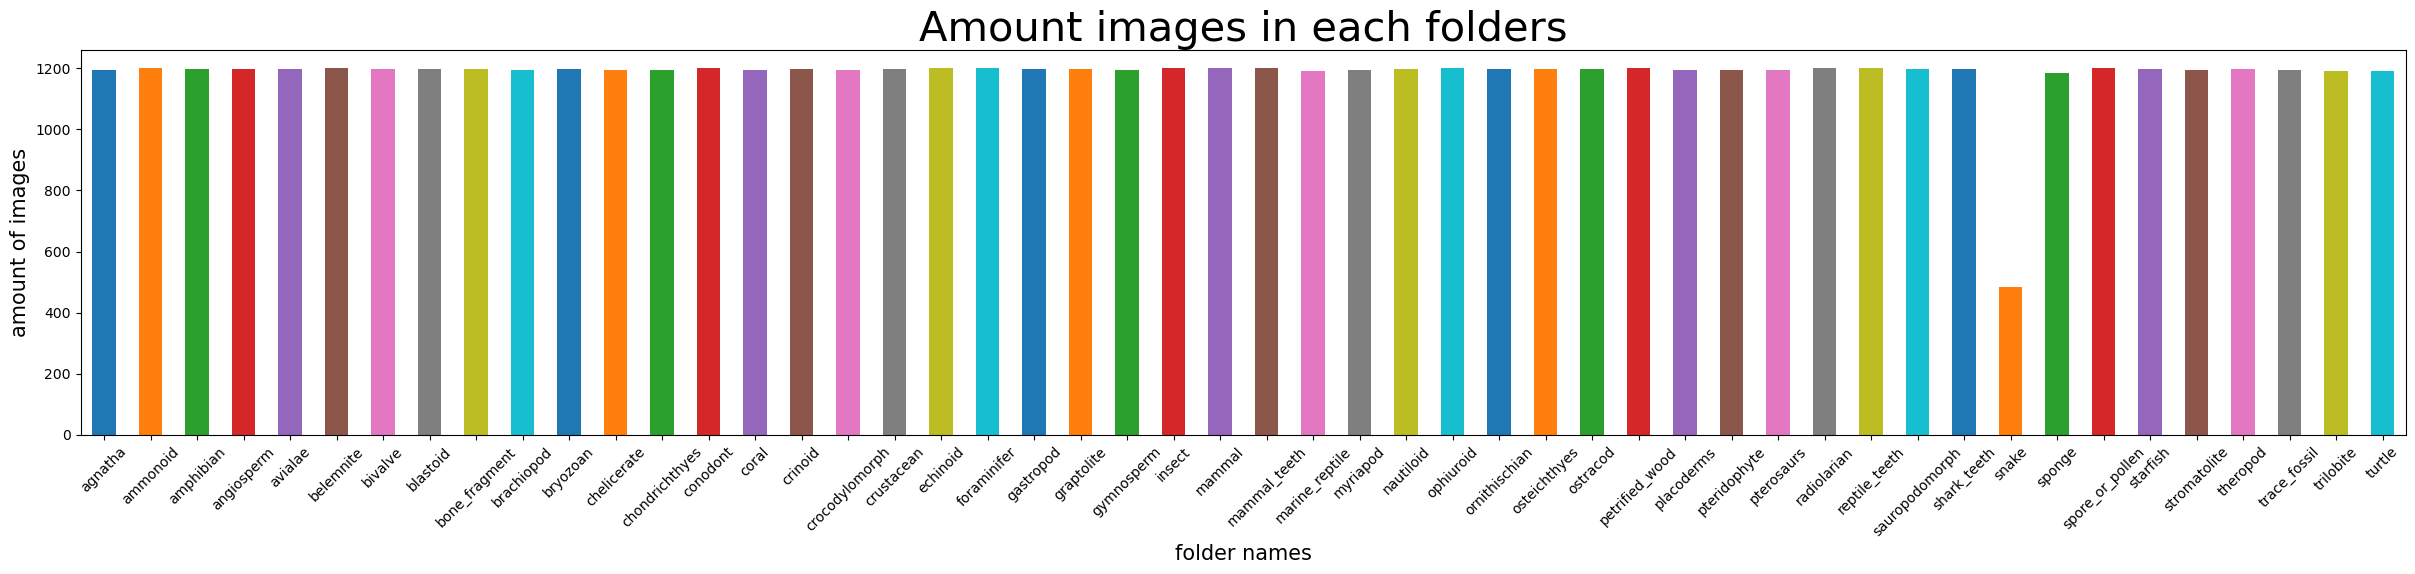

In [11]:
# Create a dictionary of kwargs
xlim_kwargs = {"left": -0.5, "right": (len(img_count) - 1) + 0.5}


# Plot the images in each folder
plt.figure(figsize=(30, 5))
for f in img_count:
    plt.bar(f, img_count.get(f), width=0.5)
plt.xlim(**xlim_kwargs)
plt.xticks(rotation=45)
plt.title("Amount images in each folders", fontsize=30)
plt.xlabel("folder names", fontsize=15)
plt.ylabel("amount of images", fontsize=15)
plt.show()


Each folder has the same number of images except snakes where we had duplicates or couldn't open these images.

### Estimate the noise images

Estimating the noise level in images can be a tricky task. The goal is to identify the amount of noise present in an image and to apply denoising techniques accordingly. However, computing the noise and applying denoising methods can be computationally expensive. That's why I've chosen to work with grayscale images, this significantly reduces computational complexity, leading to faster results.

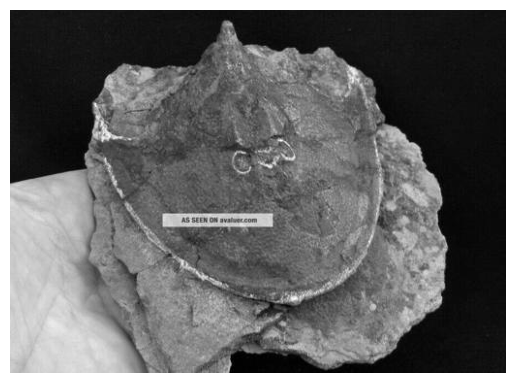

In [12]:
import cv2

image = cv2.imread("data/reduced-FID/reduced-FID\\agnatha\\agnatha_1.jpg", cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap="gray")
plt.axis("off")
plt.show()

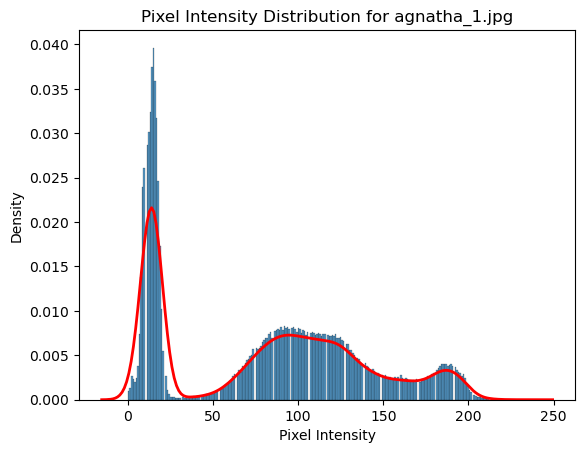

In [13]:
import seaborn as sns

# Flatten the image to obtain a 1D array of pixel intensities
pixels = image.flatten()

# Plot the histogram
sns.histplot(pixels, bins=256, kde=False, stat="density")
# Plot the curve 
sns.kdeplot(pixels, color="red", lw=2,)


plt.title("Pixel Intensity Distribution for agnatha_1.jpg")
plt.xlabel("Pixel Intensity")

plt.show()

The Pixel Intensity Distribution for this image cannot provide a direct indication of the noise level. So, I will assume that the noise in the image follows a Gaussian distribution. This is done for simplification. It's based on the assumption that a lot of natural and electronic processes result in noise that can be approximated by a normal distribution.




### Estimating noise 

The goal here is to estimate the noise in the images and to perform denoising. Denoising can help improve the visual quality of the image, and at the same time, enhance the performance of our classifier.

Here are the steps involved:

1. Store the original data type. This is important because image processing operations will change the data type, and it's necessary to convert it back to the original type after processing.

2. Convert the image to a float data type and normalize the pixel values to range between 0 and 1. This is accomplished using the function ``img_as_float`` from scikit-image.

3. Estimate the standard deviation of the noise from an image using the ``estimate_sigma`` function from scikit-image. In essence, the function examines the image to determine how much variation, or "noise", is present. This is returned as a numerical value, the standard deviation of the noise, using a method based on the wavelet coefficients.

4. Apply a denoising method, such as ``denoise_nl_means`` or Non-Local Means Denoising method. Here are the different parameters used:

    - The parameter ``h`` determines the amount of smoothing (denoising) to perform. It will be set dynamically by multiplying 1.15 by the sigma_est.
    - Rescale the denoised image to ensure pixel values remain within the [0, 1] range using the ``np.clip`` function.
<br><br>

5. Convert the denoised image back to the original data type and the original pixel range using the expression ``(denoised * np.iinfo(original_datatype).max)``. This is used for rescaling the denoised image to [0, 255]. Once this is done, we change the format to ``uint8``.

All these steps are performed with grayscale images to yield faster results.
    

In [14]:
from skimage import img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma

# Store the original data type
original_datatype = image.dtype

# Convert the image to float and normalize the pixel to [0, 1].
I = img_as_float(image)

# Estimate the noise standard deviation from the image.
sigma_est = estimate_sigma(I, channel_axis=None, average_sigmas=True)
print(f"estimated the standard devation of the noise = {round(sigma_est, 4)} based on wavelet coefficients")

# Perform Non-local means denoising
factor = 1.1
h = factor * sigma_est
denoised = denoise_nl_means(I, h=h * sigma_est, fast_mode=True)

# Rescale the denoised image to original scale
denoised = np.clip(denoised, 0, 1)

# Convert the denoised image back to original datatype and original range
denoised = (denoised * np.iinfo(original_datatype).max).astype(original_datatype)

estimated the standard devation of the noise = 0.003 based on wavelet coefficients


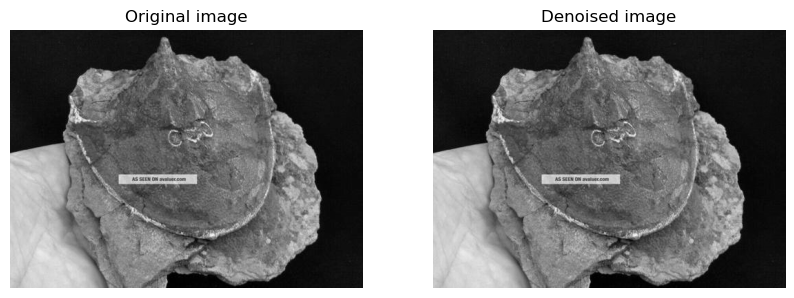

In [15]:
# Display the denoised images vs original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))

ax1.imshow(image, cmap="gray")
ax1.axis("off")
ax1.set_title("Original image")

ax2.imshow(denoised, cmap="gray")
ax2.axis("off")
ax2.set_title("Denoised image")

plt.show()

Next, I will estimate the standard deviation of the noise for all images and visualise the result using a histogram. This is done to have a big picture of the noise of images contained in my database.

Below I'm using Scikit-Image Library to perform the following:
- Read the image using ``io.imread``
- Convert to gray scale using ``color.rgb2gray``
- Resize the images with ``resize`` where ``order`` is set to 0. This is the same as ``cv2.INTER_NEAREST`` (nearest-neighbor).

When running the code below, I encountered warning messages. To troubleshoot this issue, I implemented error handling and used if statements to check for empty or invalid pixel values.

In [16]:
from skimage import io, color
from skimage.transform import resize

# Compute the noise image and save it in a dictionary

# Initialise empty dictionary and list
image_to_check = []
sigma_noise_for_all_images = {}

# Save images of each category in a numpy array
for file_name in img_paths:
    paths = img_paths.get(file_name)
    # Initialize the key with an empty list
    sigma_noise_for_all_images[file_name] = []

    # Loop over list of paths
    for path in paths:
        try:
            # Load images in RGB
            image = io.imread(path)

            # Check if the image is empty or has invalid pixel values
            if image is None or image.size == 0 or not np.all(np.isfinite(image)):
                image_to_check.append(path)
                print(f"Invalid image: {path}")
                continue

            # Convert it to gray
            gray_image = color.rgb2gray(image)

            # Resize the image
            gray_image = resize(gray_image, (224, 224), order=1)

            # Convert the image to float and normalize the pixel to [0, 1].
            I = img_as_float(gray_image)

            # Check if the image is empty or has invalid pixel values after conversion
            if I is None or I.size == 0 or not np.all(np.isfinite(I)):
                image_to_check.append(path)
                print(f"Invalid image after conversion: {path}")
                continue

            # Estimate the noise standard deviation from the image.
            if np.any(np.isfinite(I)) and np.any(I):
                sigma_noise = estimate_sigma(I, channel_axis=None, average_sigmas=True)
                # Check if the calculated noise is valid
                if not np.isfinite(sigma_noise):
                    image_to_check.append(path)
                    print(f"Invalid noise standard deviation: {path}")
                    continue
            else:
                image_to_check.append(path)
                print(f"Invalid calculated noise: {path}")
                continue

            # Save it
            sigma_noise_for_all_images[file_name].append(sigma_noise)

        # Error handeling 
        except (FileNotFoundError, OSError) as e:
            image_to_check.append(path)
            print(f"Error loading image from path: {path}")
        except Exception as e:
            image_to_check.append(path)
            print(f"Error processing image: {path}, {str(e)}")

Invalid calculated noise: data\reduced-FID\reduced-FID\bivalve\bivalve_193.png


In [17]:
# Print the list of images to check
print("Images to check: ", image_to_check)

Images to check:  ['data\\reduced-FID\\reduced-FID\\bivalve\\bivalve_193.png']


I will display the image.

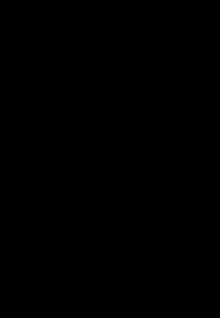

In [18]:
# Display the image
Image.open(image_to_check[0])

I also found a white image. 

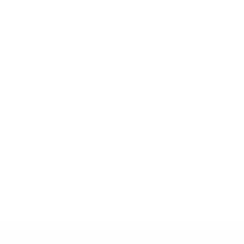

In [19]:
# Display white image
Image.open('data/reduced-FID/reduced-FID/belemnite/belemnite_685.jpg').resize((244, 244))

I will remove tem

In [20]:
os.remove(image_to_check[0])
os.remove('data/reduced-FID/reduced-FID/belemnite/belemnite_685.jpg')

It seems we have monochromatic (image of only one color) in the dataset. I will check for monochromatic images in the dataset.

Number of monochromatic image: 1


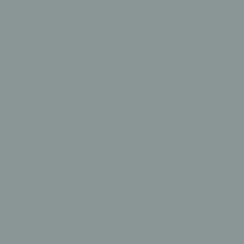

In [21]:
# Function to check for monochromatic images it return boolean value (Ture if monochromatic)
def is_monochromatic_img(path):
    # load image
    img = io.imread(path)
    # Convert to grayscale
    img_gray = color.rgb2gray(img)

    # Check if the image is monochromatic
    mono = (img_gray.min() == img_gray.max())
    
    return mono


# Initialize placeholder variable
path_monochromatic_img = []

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):

    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        for img_name in os.listdir(subfolder_path):
            # Save the full path for each image
            img_path = os.path.join(subfolder_path, img_name)

            # Check if the image is monochromatic
            if is_monochromatic_img(img_path):
                # if True I save the path
                path_monochromatic_img.append(img_path)


print("Number of monochromatic image:", len(path_monochromatic_img))

# Visualize these images
for path in path_monochromatic_img[:4]:
    display(Image.open(path).resize((244, 244)))

I will remove all monochromatic images they are not useful.

In [22]:
# Remove all monochromatic images
for path in path_monochromatic_img:
    os.remove(path)

I will estimate again the noise just to be sure the monochromatic images are not influencing the results. Below I'm estimating noise and saving the new path.

In [23]:
# Initialise empty dictionary and list
img_paths = {}
sigma_noise_for_all_images = {}

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):

    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)
    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        # Initialize the key with an empty list
        sigma_noise_for_all_images[subfolder_name] = []
        img_paths[subfolder_name] = []

        for img_name in os.listdir(subfolder_path):
            # Save the full path for each image
            img_path = os.path.join(subfolder_path, img_name)

            # Save image paths
            img_paths[subfolder_name].append(img_path)


            # Next, compute the noise image and save it in a dictionary 
            # Load images in RGB
            image = io.imread(img_path)

            # Convert it to gray
            gray_image = color.rgb2gray(image)

            # Resize the image
            gray_image = resize(gray_image, (224, 224), order=1)

            # Convert the image to float and normalize the pixel to [0, 1].
            I = img_as_float(gray_image)

            # Estimate the noise standard deviation from the image.
            sigma_noise = estimate_sigma(I, channel_axis=None, average_sigmas=True)
                
            # Save it
            sigma_noise_for_all_images[subfolder_name].append(sigma_noise)

### Visualize estimated noise based on wavelet coefficients

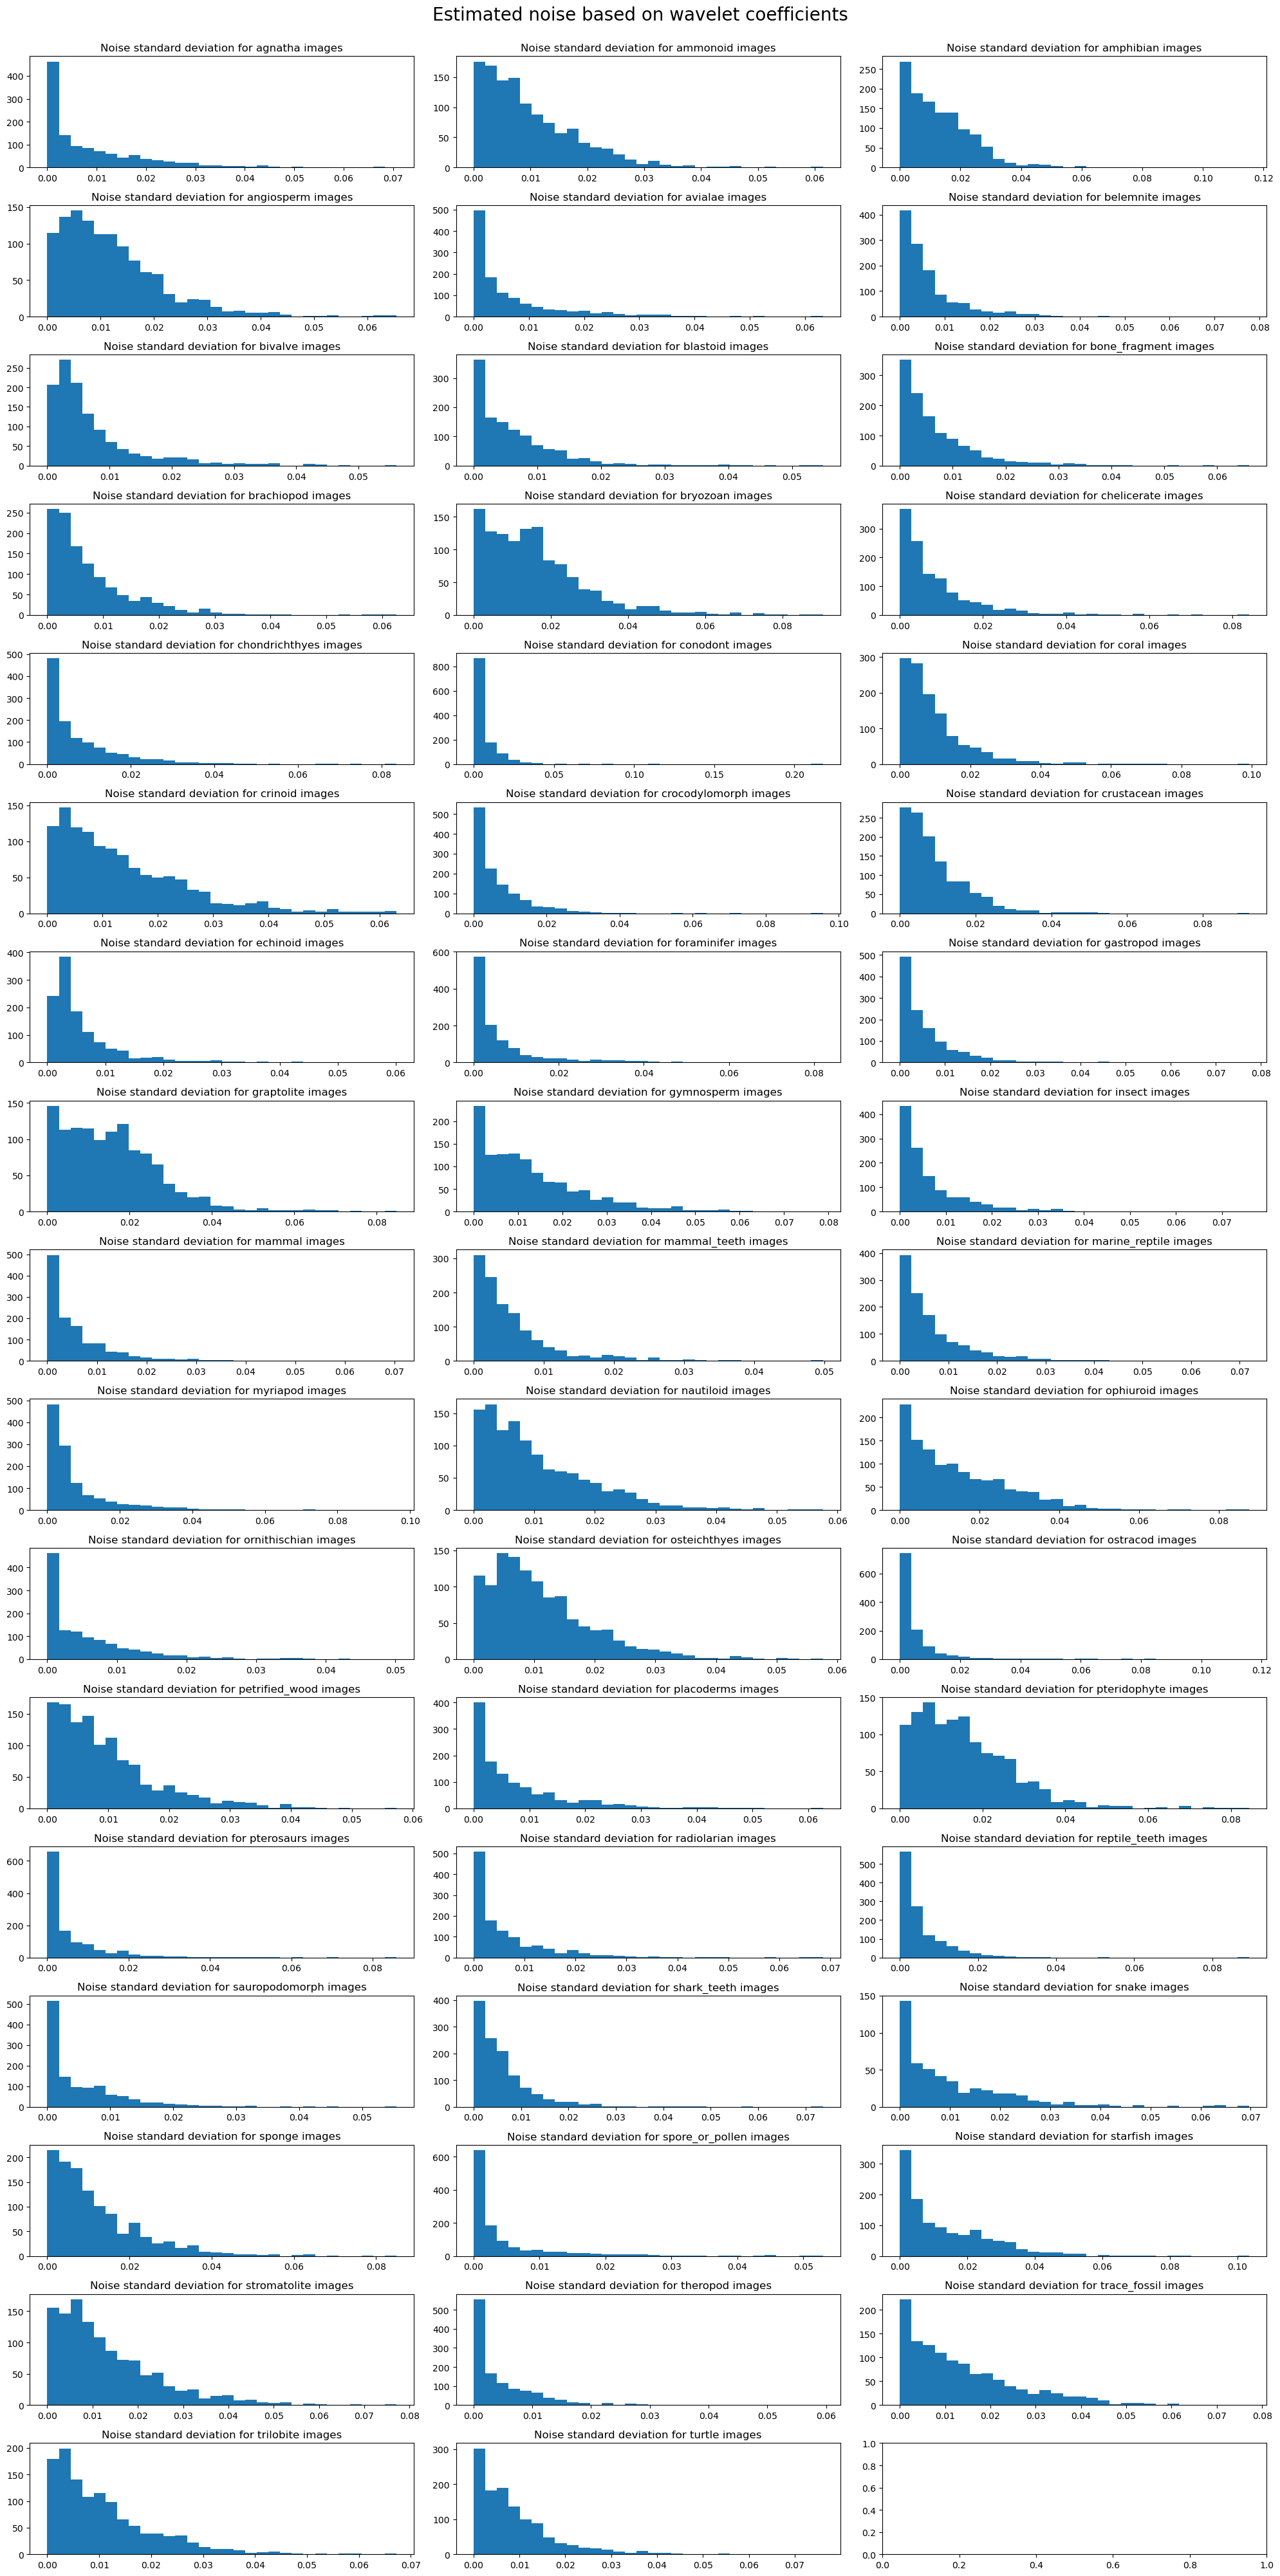

In [24]:
# Plot the standard deviation for each directory

# Create subplots for each label
fig, axs = plt.subplots(nrows=17, ncols=3, figsize=(20, 40))
ax = axs.flatten()

for i, file_name in enumerate(sigma_noise_for_all_images):
    sigma_noise = sigma_noise_for_all_images.get(file_name)
    ax[i].hist(sigma_noise, bins=30)
    ax[i].set(
        title=f"Noise standard deviation for {file_name} images"
    )

plt.suptitle("Estimated noise based on wavelet coefficients", fontsize=20, y=1.0)
plt.tight_layout()
plt.show()

The noise is so small that it will not impact the performance of the classifiers.

### Examining the Contrast and Saturation of Images
__Goal:__ The goal is to investigate the contrast and saturation of an image using plots to detect unusual patterns, such as spikes or irregularities.

__Steps for Computing Contrast and Saturation:__

1. __Load the Image and Convert to HSV Color Space:__

- Load the image.
- Convert the image to the HSV (Hue, Saturation, Value) color space.
2. __Compute the Contrast:__

- Extract the Value (V) channel from the HSV image.
- Calculate the contrast by finding the difference between the maximum and minimum intensity values in the Value channel: ``contrast = max(V) - min(V)``.
3. __Compute the Average Saturation:__

- Extract the Saturation (S) channel from the HSV image.
- Calculate the average saturation by taking the mean of the values in the Saturation channel: ``average_saturation = np.mean(saturation_channel)``.
4. __Plot the Results:__

- Create histograms to display the computed contrast and saturation values.
- Interpret the histograms to identify any unusual patterns or spikes in the data.

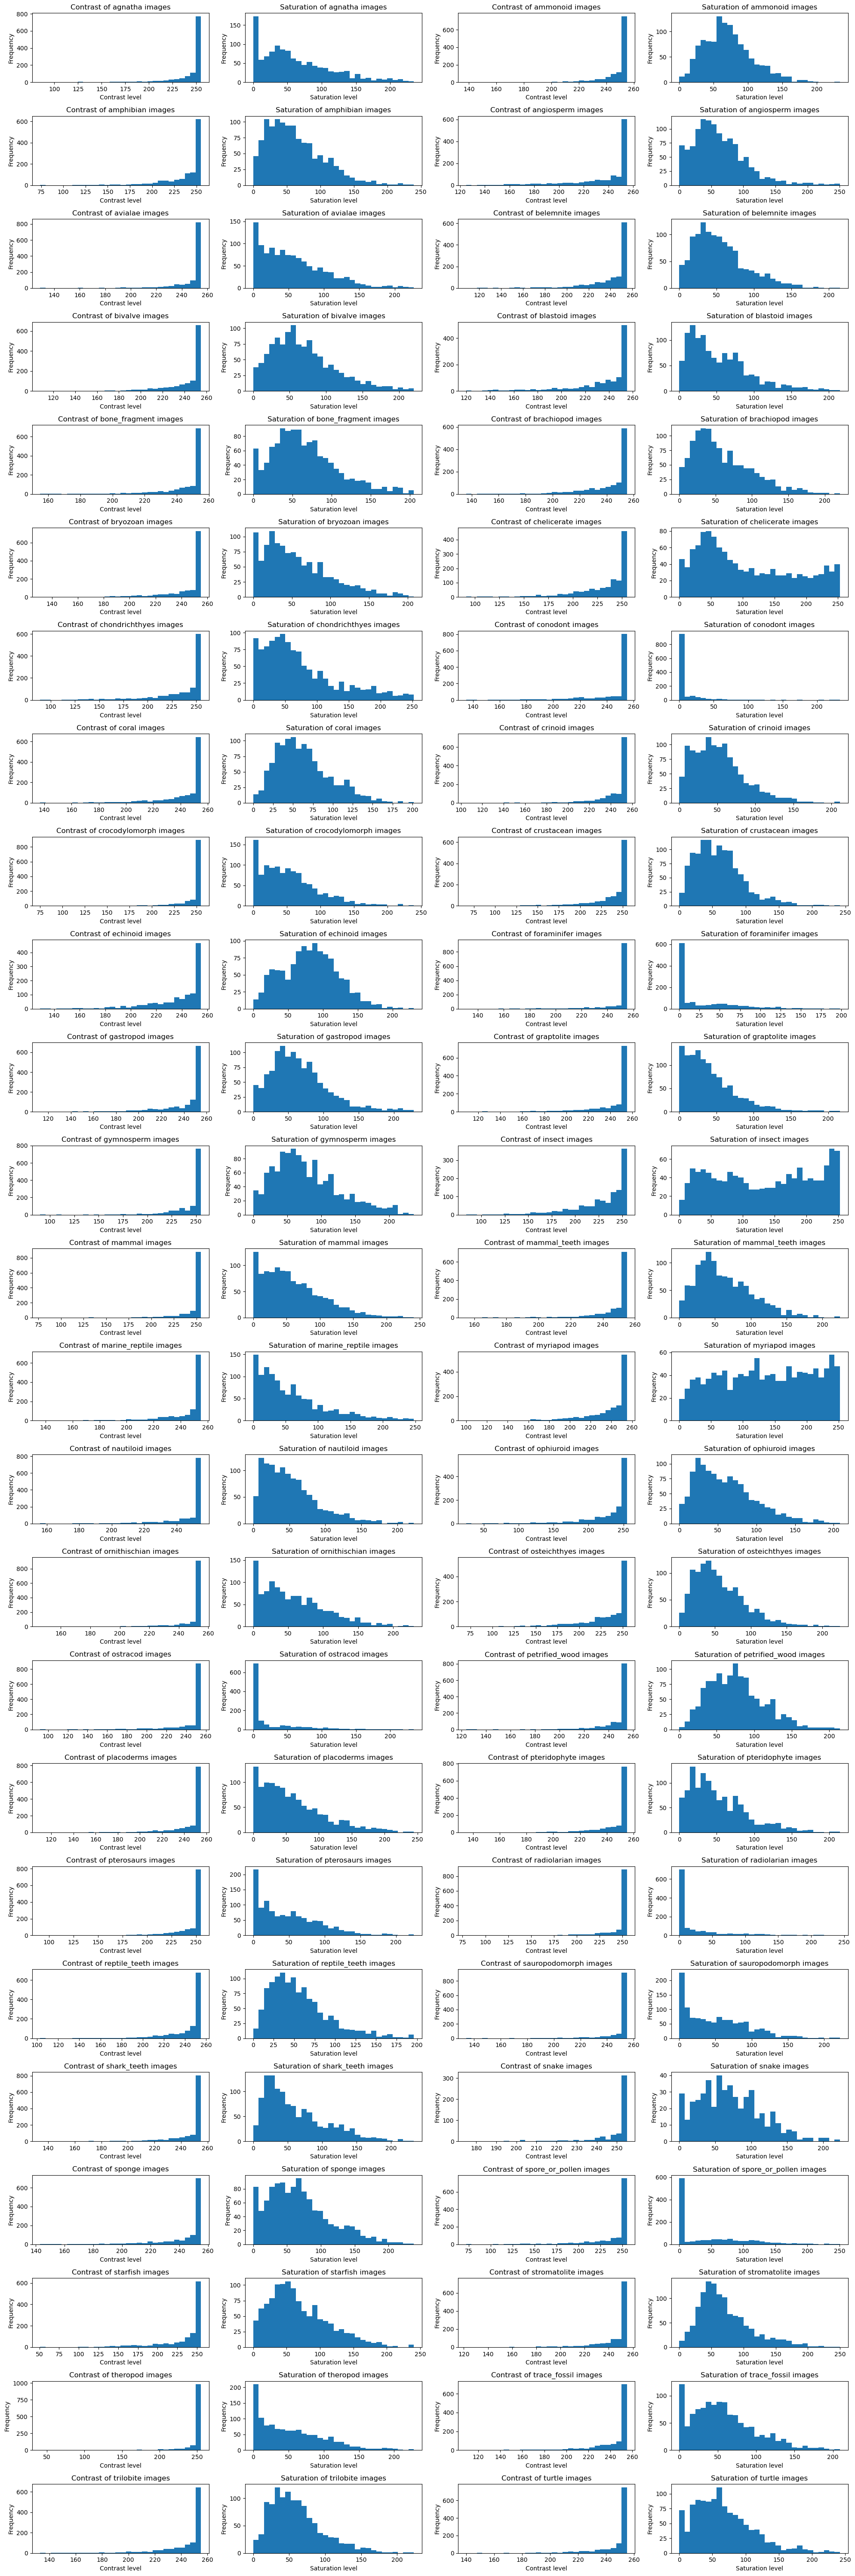

In [25]:
# Initialise empty dictionary
dict_contrast = {}
dict_saturation = {}

# Save images of each categorie in a numpy array
for file_name in img_paths:
    paths = img_paths.get(file_name)
    # Initialise the key with an empty list
    dict_contrast[file_name] = []
    dict_saturation[file_name] = []
    
    for path in paths:
        # load image and convert to a HSV format
        image = cv2.imread(path) 

        # Convert to HSV color space
        hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        
        # Compute the contrast
        value_channel = hsv_image[:,:,2]
        (min_contrast, max_contrast) = value_channel.min(), value_channel.max()
        contrast = max_contrast - min_contrast
        # Save result
        dict_contrast[file_name].append(contrast)

        # Compute the average saturation
        average_saturation = hsv_image[:,:,1].mean()
        # Save result 
        dict_saturation[file_name].append(average_saturation)

# Plot the the results

# Create subplots for each label
fig, axs = plt.subplots(nrows=25, ncols=4, figsize=(20, 60))
ax = axs.flatten()

for i, file_name in enumerate(dict_contrast):
    contrast = dict_contrast.get(file_name)
    saturation = dict_saturation.get(file_name)
    ax[i*2].hist(contrast, bins=30)
    ax[i*2].set(
        title=f"Contrast of {file_name} images",
        xlabel="Contrast level",
        ylabel="Frequency",

    )

    ax[i*2+1].hist(saturation, bins=30)
    ax[i*2+1].set(
        title=f"Saturation of {file_name} images",
        xlabel="Saturation level",
        ylabel="Frequency",
    )

plt.tight_layout()
plt.show()

By looking contrast, we see a lot of images have black colors in them. On the other hand, when looking at the saturation images certain classes  (e.g. ``conodont``) tend to have no vibrant colors and appears to be a grayscale image.


### Visualising monochrome images 
Why the plot show a trend towards monochrome pattern? 
Below I will display only monochrome categories.

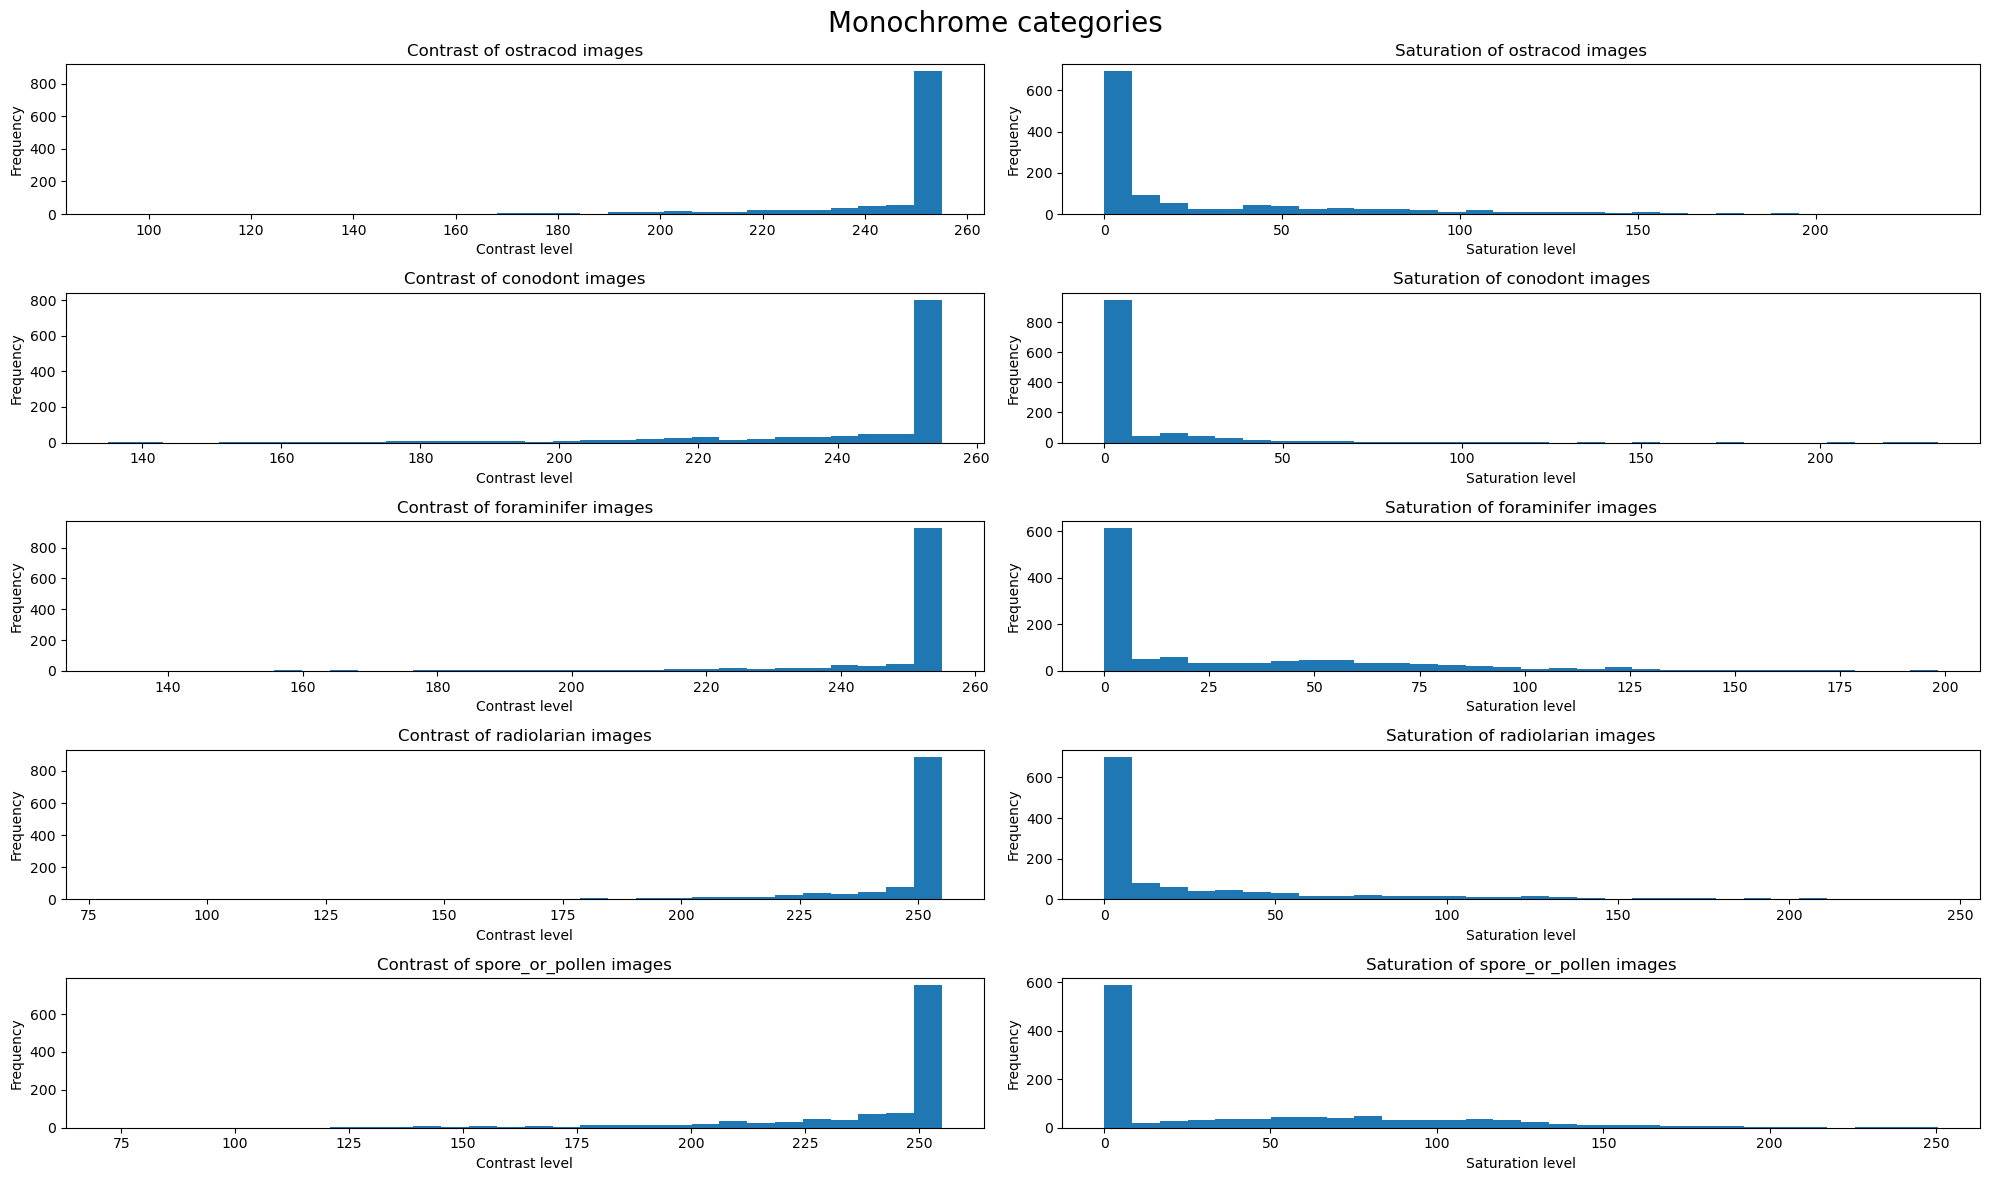

In [26]:
monochrome_categories = ["ostracod", "conodont", "foraminifer", "radiolarian", "spore_or_pollen"]

# Create subplots for "conodont" 
fig, axs = plt.subplots(nrows=len(monochrome_categories), ncols=2, figsize=(20, 12))


for i, name in enumerate(monochrome_categories):


    contrast = dict_contrast.get(name)
    saturation = dict_saturation.get(name)

    # Plot 1
    axs[i, 0].hist(contrast, bins=30)
    axs[i, 0].set(
        title=f"Contrast of {name} images",
        xlabel="Contrast level",
        ylabel="Frequency",

    )

    # Plot 2
    axs[i, 1].hist(saturation, bins=30)
    axs[i, 1].set(
        title=f"Saturation of {name} images",
        xlabel="Saturation level",
        ylabel="Frequency",
    )
plt.suptitle(f"Monochrome categories", fontsize=20)
plt.tight_layout()
plt.show()

We see that the majority of the images in this category have a tendency towards monochrome colors. This is probably due to images scanned or photos taken in black and white. I will visualise a sample of them below.

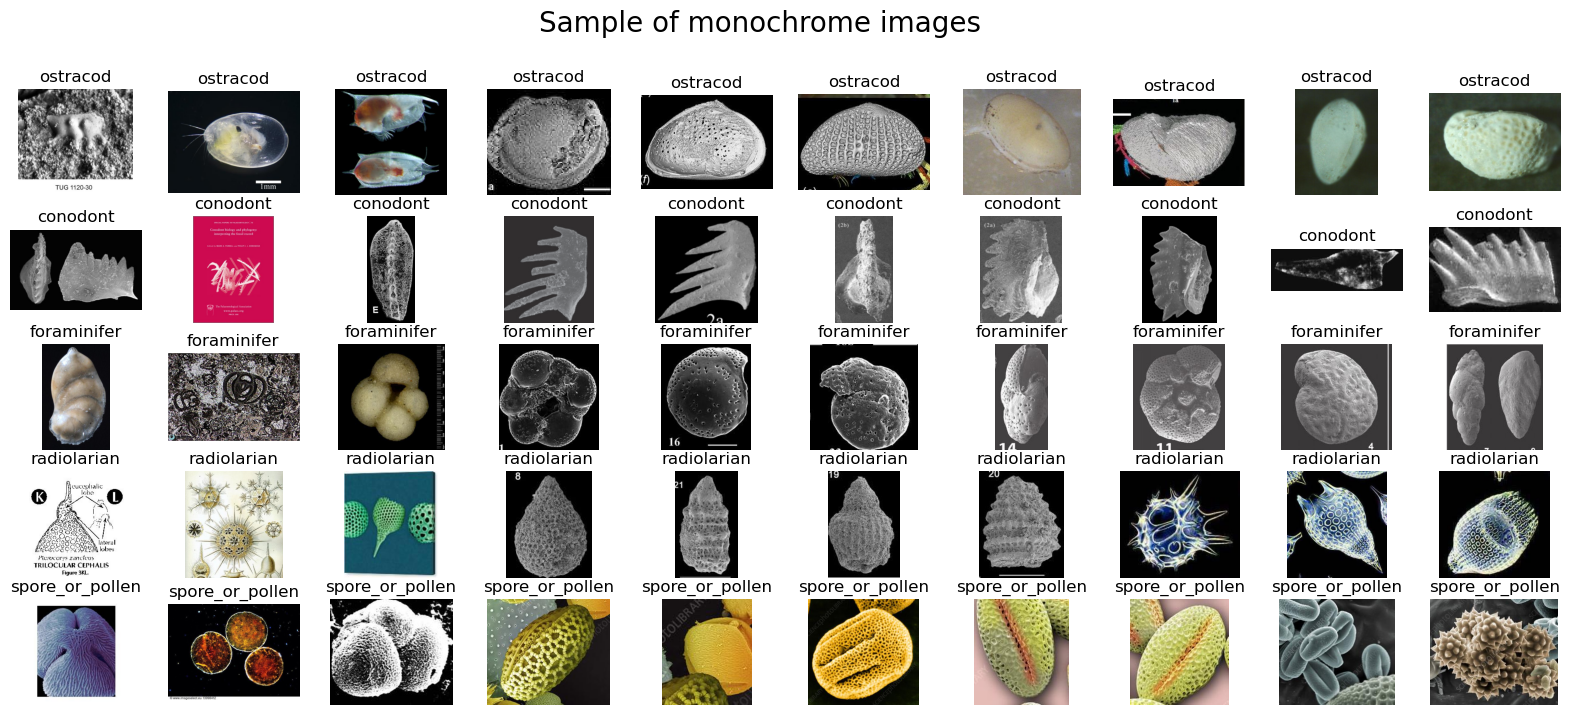

In [27]:
# Display monochrome image
fig, ax = plt.subplots(nrows=len(monochrome_categories), ncols=10, figsize=(20, 8))


# Get class name
for i, name in enumerate(monochrome_categories):
    # Display some image
    for n, path in enumerate(img_paths[name][:10]):
        img = io.imread(path)
        ax[i, n].imshow(img)
        ax[i, n].axis("off")
        ax[i, n].set_title(name)
plt.suptitle(f"Sample of monochrome images", fontsize=20)
plt.show()

We observe some irrelevant images, such as the first image in the ``radiolarian`` category. Generally, these images have a trend towards monochrome colors. These are for the most part 3D render or microscopic images. They will not be encountered in natural environments, only in a laboratory environment. Therefore, I will remove them.

I will keep ``conodont`` category they are all fossils of extinct group of agnathan.

In [28]:
# Removing monochronic images
category_to_remove = ["ostracod", "foraminifer", "radiolarian", "spore_or_pollen"]

# Loop over all subfolders in the directory
for subfolder_name in category_to_remove:
    folder_path = os.path.join(dir_path, subfolder_name)
    shutil.rmtree(folder_path)

### Blur detection 

The goal here is to detect blurry images that could hurt the performance of our classifiers.
Here are the steps:

1. Load the images using ``cv2``.
2. Compute the variance of the Laplacian. This is done to calculate the rate at which the pixel intensity changes in the image. The Laplacian by itself is not particularly useful, for example, it will give me 0 for a constant color. Therefore, we compute the variance of the Laplacian to measure the sharpness of an image. We can use this method to detect blurry or out-of-focus images as follows:

    - An image is considered blurry if it has less sharp edges, in which case the variance of the Laplacian will be lower.
    - An image is considered not blurry if it has sharp edges, which leads to a higher variance of the Laplacian.
    
We can use these parameters to set a threshold to classify them. Choosing the threshold values is a trade-off between false positives and false negatives. A lower threshold will classify more images as blurry but could include some non-blurry. On the other hand, a higher threshold may miss some blurry images. This is why I choose a small threshold. 
<br><br>
3. Save the paths of all blurry and non-blurry images in an array.


Refer to the original <a href="https://pyimagesearch.com/2015/09/07/blur-detection-with-opencv/">article</a> for more details.

In [29]:
# Initialise variables
blurry_image = []
non_blurry_image =  []
threshold = 20.0 

# Save images of each categorie in a numpy array

# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):

    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    # Check if it's a directory
    if os.path.isdir(subfolder_path):
        for img_name in os.listdir(subfolder_path):
            # Get the full path for each image
            img_path = os.path.join(subfolder_path, img_name)

            # Open the image and return a numpy array
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            # Compute the laplacian variance
            lap_var = cv2.Laplacian(image, cv2.CV_64F).var()

            if lap_var < threshold:
                blurry_image.append(img_path)
            else:
                non_blurry_image.append(img_path)

print(f"Number of blurry images = {len(blurry_image)}")
print(f"Number of non-blurry images = {len(non_blurry_image)}")

Number of blurry images = 131
Number of non-blurry images = 54196


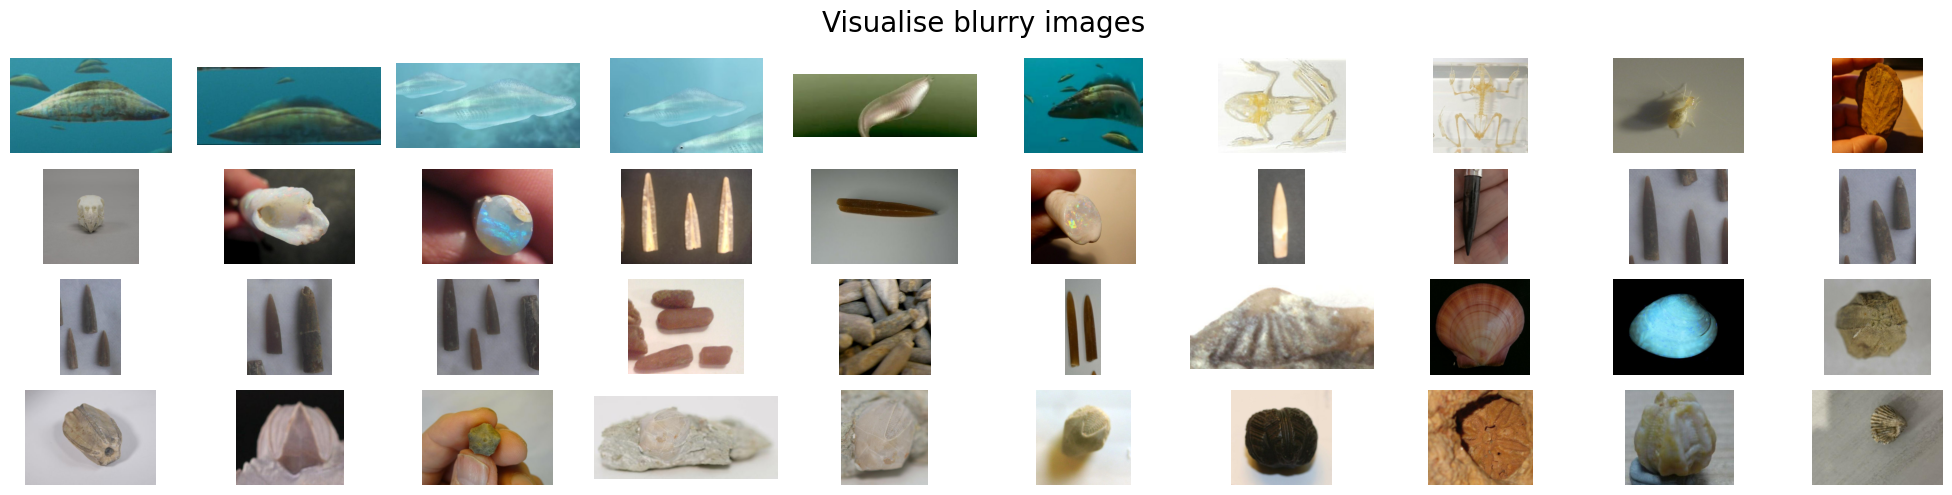

In [30]:
# Visualise some blurry images
fig, axis = plt.subplots(nrows=4, ncols=10, figsize=(20, 5))

for ax, path in zip(axis.ravel(), blurry_image[:40]):
    img = io.imread(path)
    ax.imshow(img)
    ax.axis("off")
plt.suptitle("Visualise blurry images", fontsize=20)
plt.tight_layout()
plt.show()

### Deblurring images

I will try to deblur the images using the ``filters.unsharp_mask`` form ``skimage`` to enhance the images. This is a simple method but should give good results.
Here is the basic idea. 

```enhanced image = original + amount * (original - blurred)```

1. First it creates a blurry version of the original image
2. The blurry images is then subtracted from the original image to create a "mask" which represent the details of the images
3. The mask is then added to the original image to enhance the detail of the images.

documentation: 
- <a href="https://scikit-image.org/docs/stable/auto_examples/filters/plot_unsharp_mask.html">Unsharp masking scikit-image<a>

- <a href=https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking>Digital unsharp masking explained</a> 


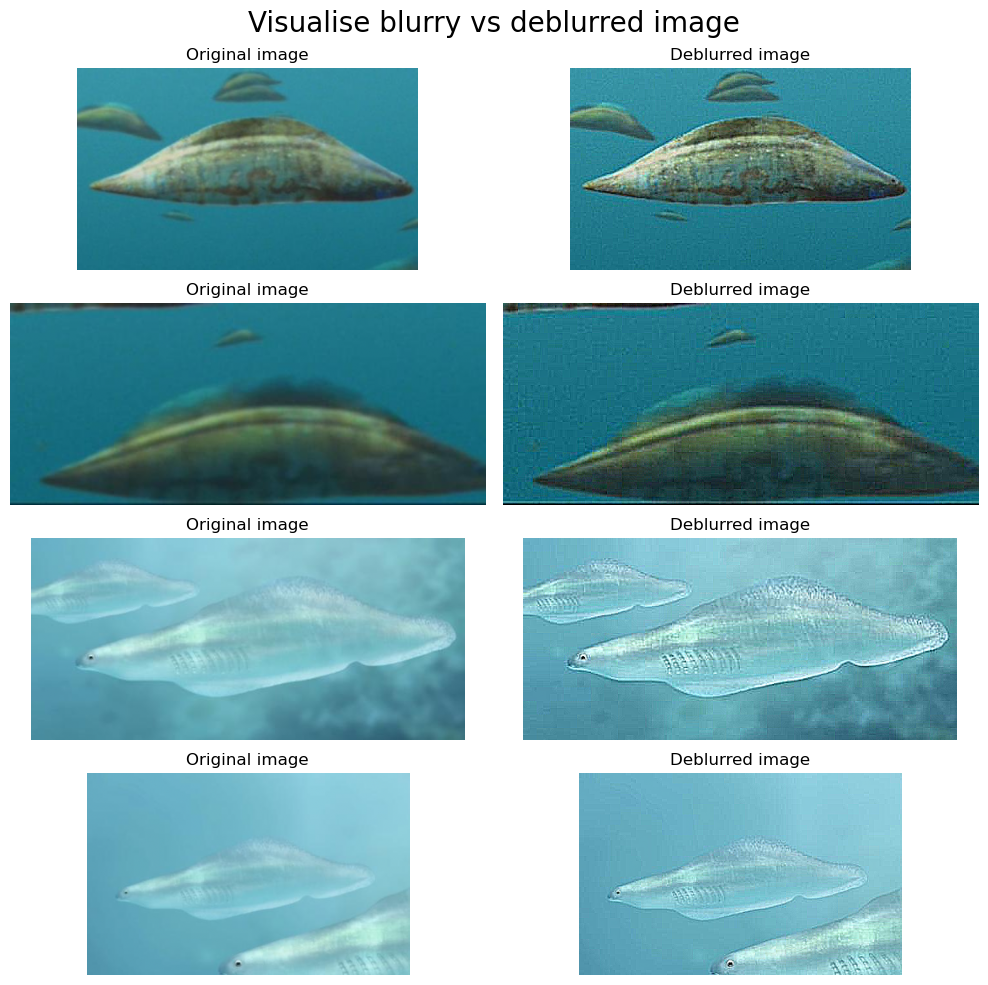

In [31]:
from skimage.filters import unsharp_mask

# Visualise some blurry images
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10, 10))


for i, path in enumerate(blurry_image[:4]):

    # Display original
    img = img_as_float(io.imread(path))
     
    ax[i, 0].imshow(img)
    ax[i, 0].set_title("Original image")
    ax[i, 0].axis("off")

    # Deblurred images
    image_deblurred = unsharp_mask(img, radius=1.0, amount=10.0, channel_axis=2)

    # Display the deblurred image
    ax[i, 1].imshow(image_deblurred)
    ax[i, 1].set_title("Deblurred image")
    ax[i, 1].axis("off")


plt.suptitle("Visualise blurry vs deblurred image", fontsize=20)
plt.tight_layout()
plt.show()

The results are okay, but we still get somewhat blurry images. To achieve better results, I could use more powerful methods, such as NAFNet. Below is an example (screenshot) of deburring the first image using this method. <a href="https://replicate.com/megvii-research/nafnet">NAFNet demo</a>. [Github  NAFNet repo](https://github.com/megvii-research/NAFNet) <br><br> 
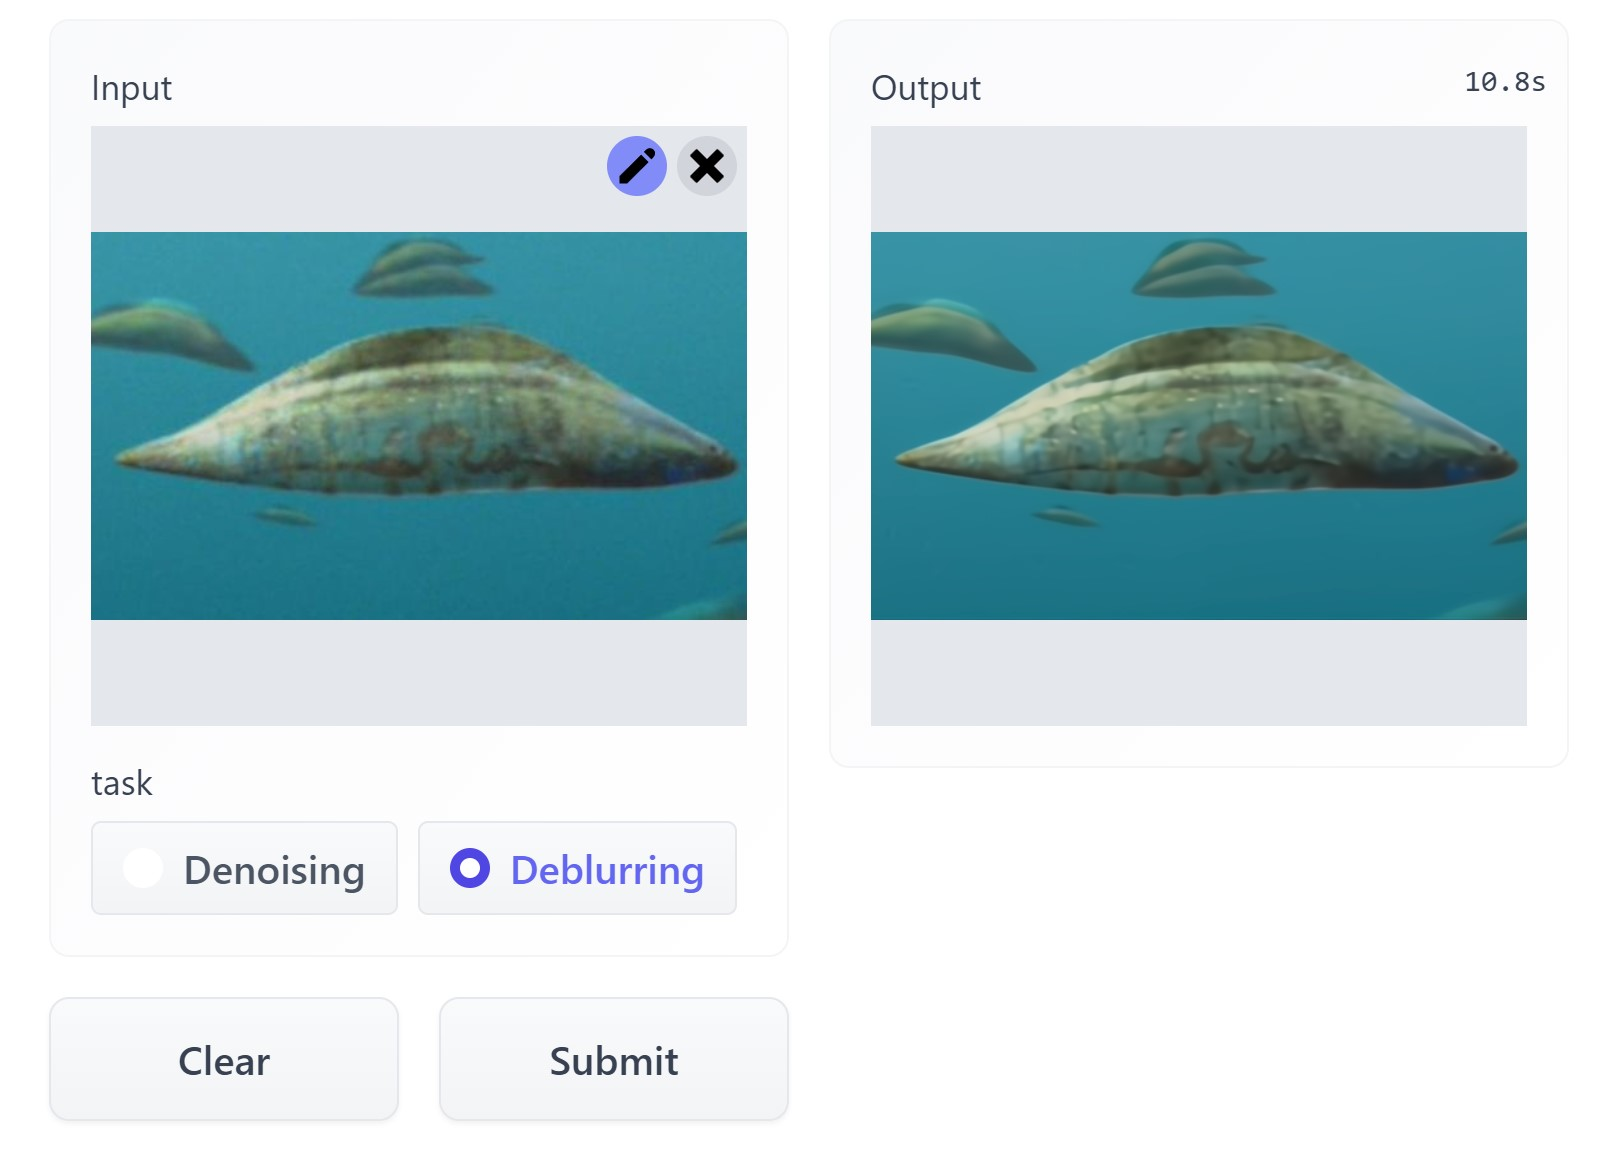
 Even with a pretrained model has trouble deburring the image. So, to minimise the chance of heating the performance of my classifier. I will remove them.     

In [32]:
for path in blurry_image: 
    try:
        os.remove(path)
    except:
        print(f"can't remove: {path}")

# Visualize the number of images after removing blurry and monochrome images

Number of categories: 46
Number of images: 54196


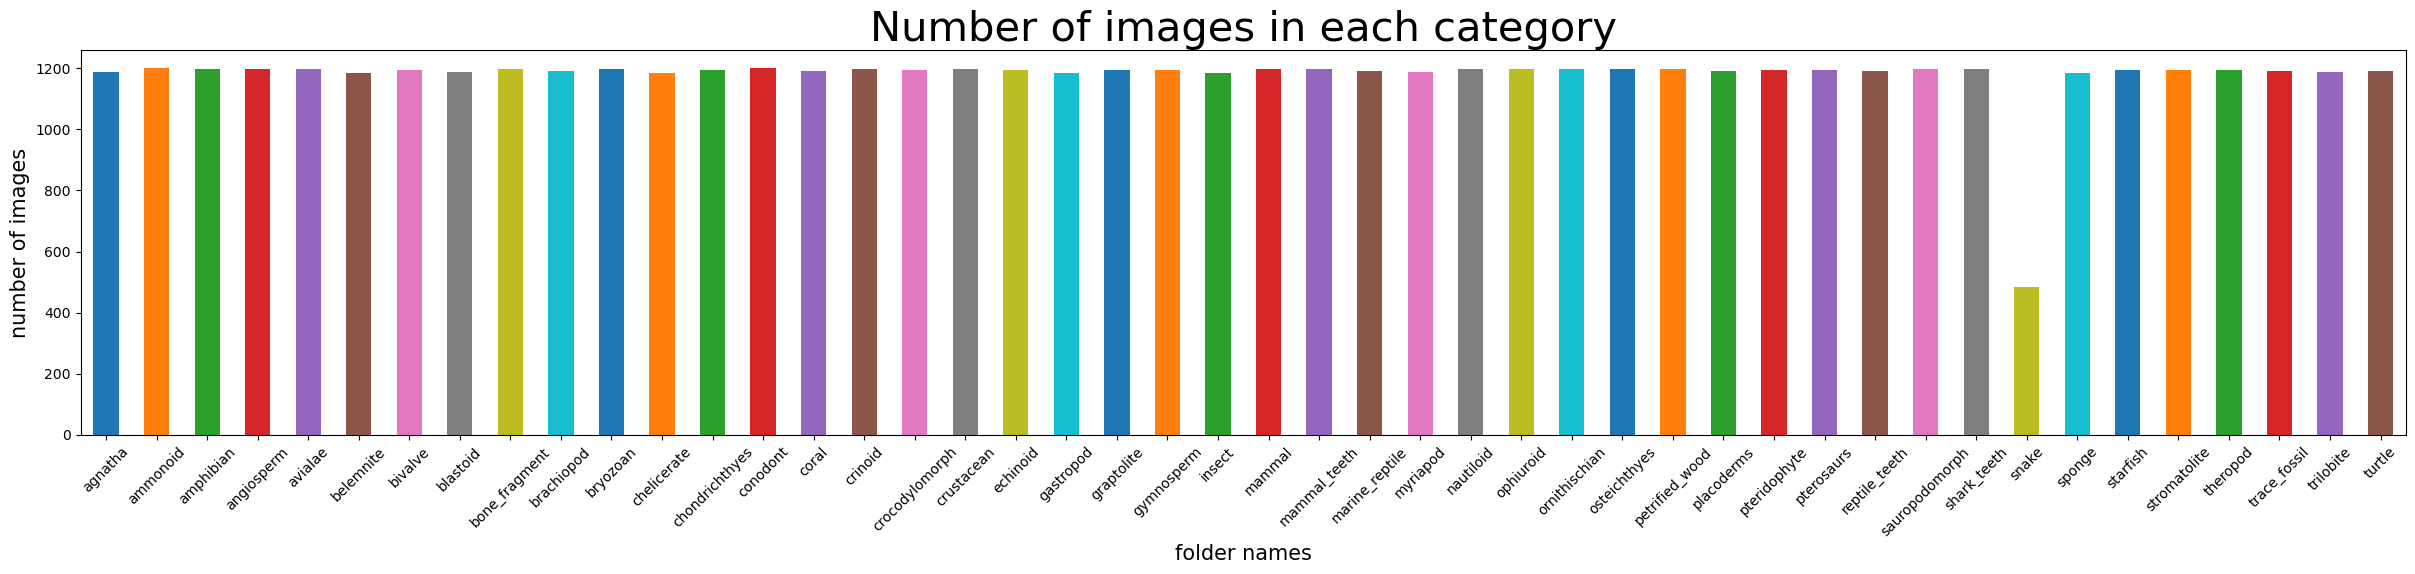

In [33]:
# Initialise empty dictionary and list
img_paths = {}
img_count = {}


# Loop over all subfolders in the directory
for subfolder_name in os.listdir(dir_path):

    # Get the full path to the subfolder
    subfolder_path = os.path.join(dir_path, subfolder_name)

    if os.path.isdir(subfolder_path):
        
        # Save number of images and class name
        img_count[subfolder_name] = len(os.listdir(subfolder_path))
        
        # Initialise the key with an empty list
        img_paths[subfolder_name] = []
        for img_name in os.listdir(subfolder_path):
            # Save the full path for each image
            img_path = os.path.join(subfolder_path, img_name)

            # Save image paths
            img_paths[subfolder_name].append(img_path)

        
print("Number of categories:", len(img_count))
print("Number of images:", sum(img_count.values()))


# Create a dictionary of kwargs
xlim_kwargs = {"left": -0.5, "right": (len(img_count) - 1) + 0.5}

# Plot the images in each folder
plt.figure(figsize=(30, 5))
for f in img_count:
    plt.bar(f, img_count.get(f), width=0.5)
plt.xlim(**xlim_kwargs)
plt.xticks(rotation=45)
plt.title("Number of images in each category", fontsize=30)
plt.xlabel("folder names", fontsize=15)
plt.ylabel("number of images", fontsize=15)
plt.show()

After completing all the cleaning steps, we ended up removing 4933 images.

By removing images, we change the distribution of the dataset. However, this shouldn't impact the performance of our classifier.

### Plot a colour histogram that shows the statistic of the three colours for each label.

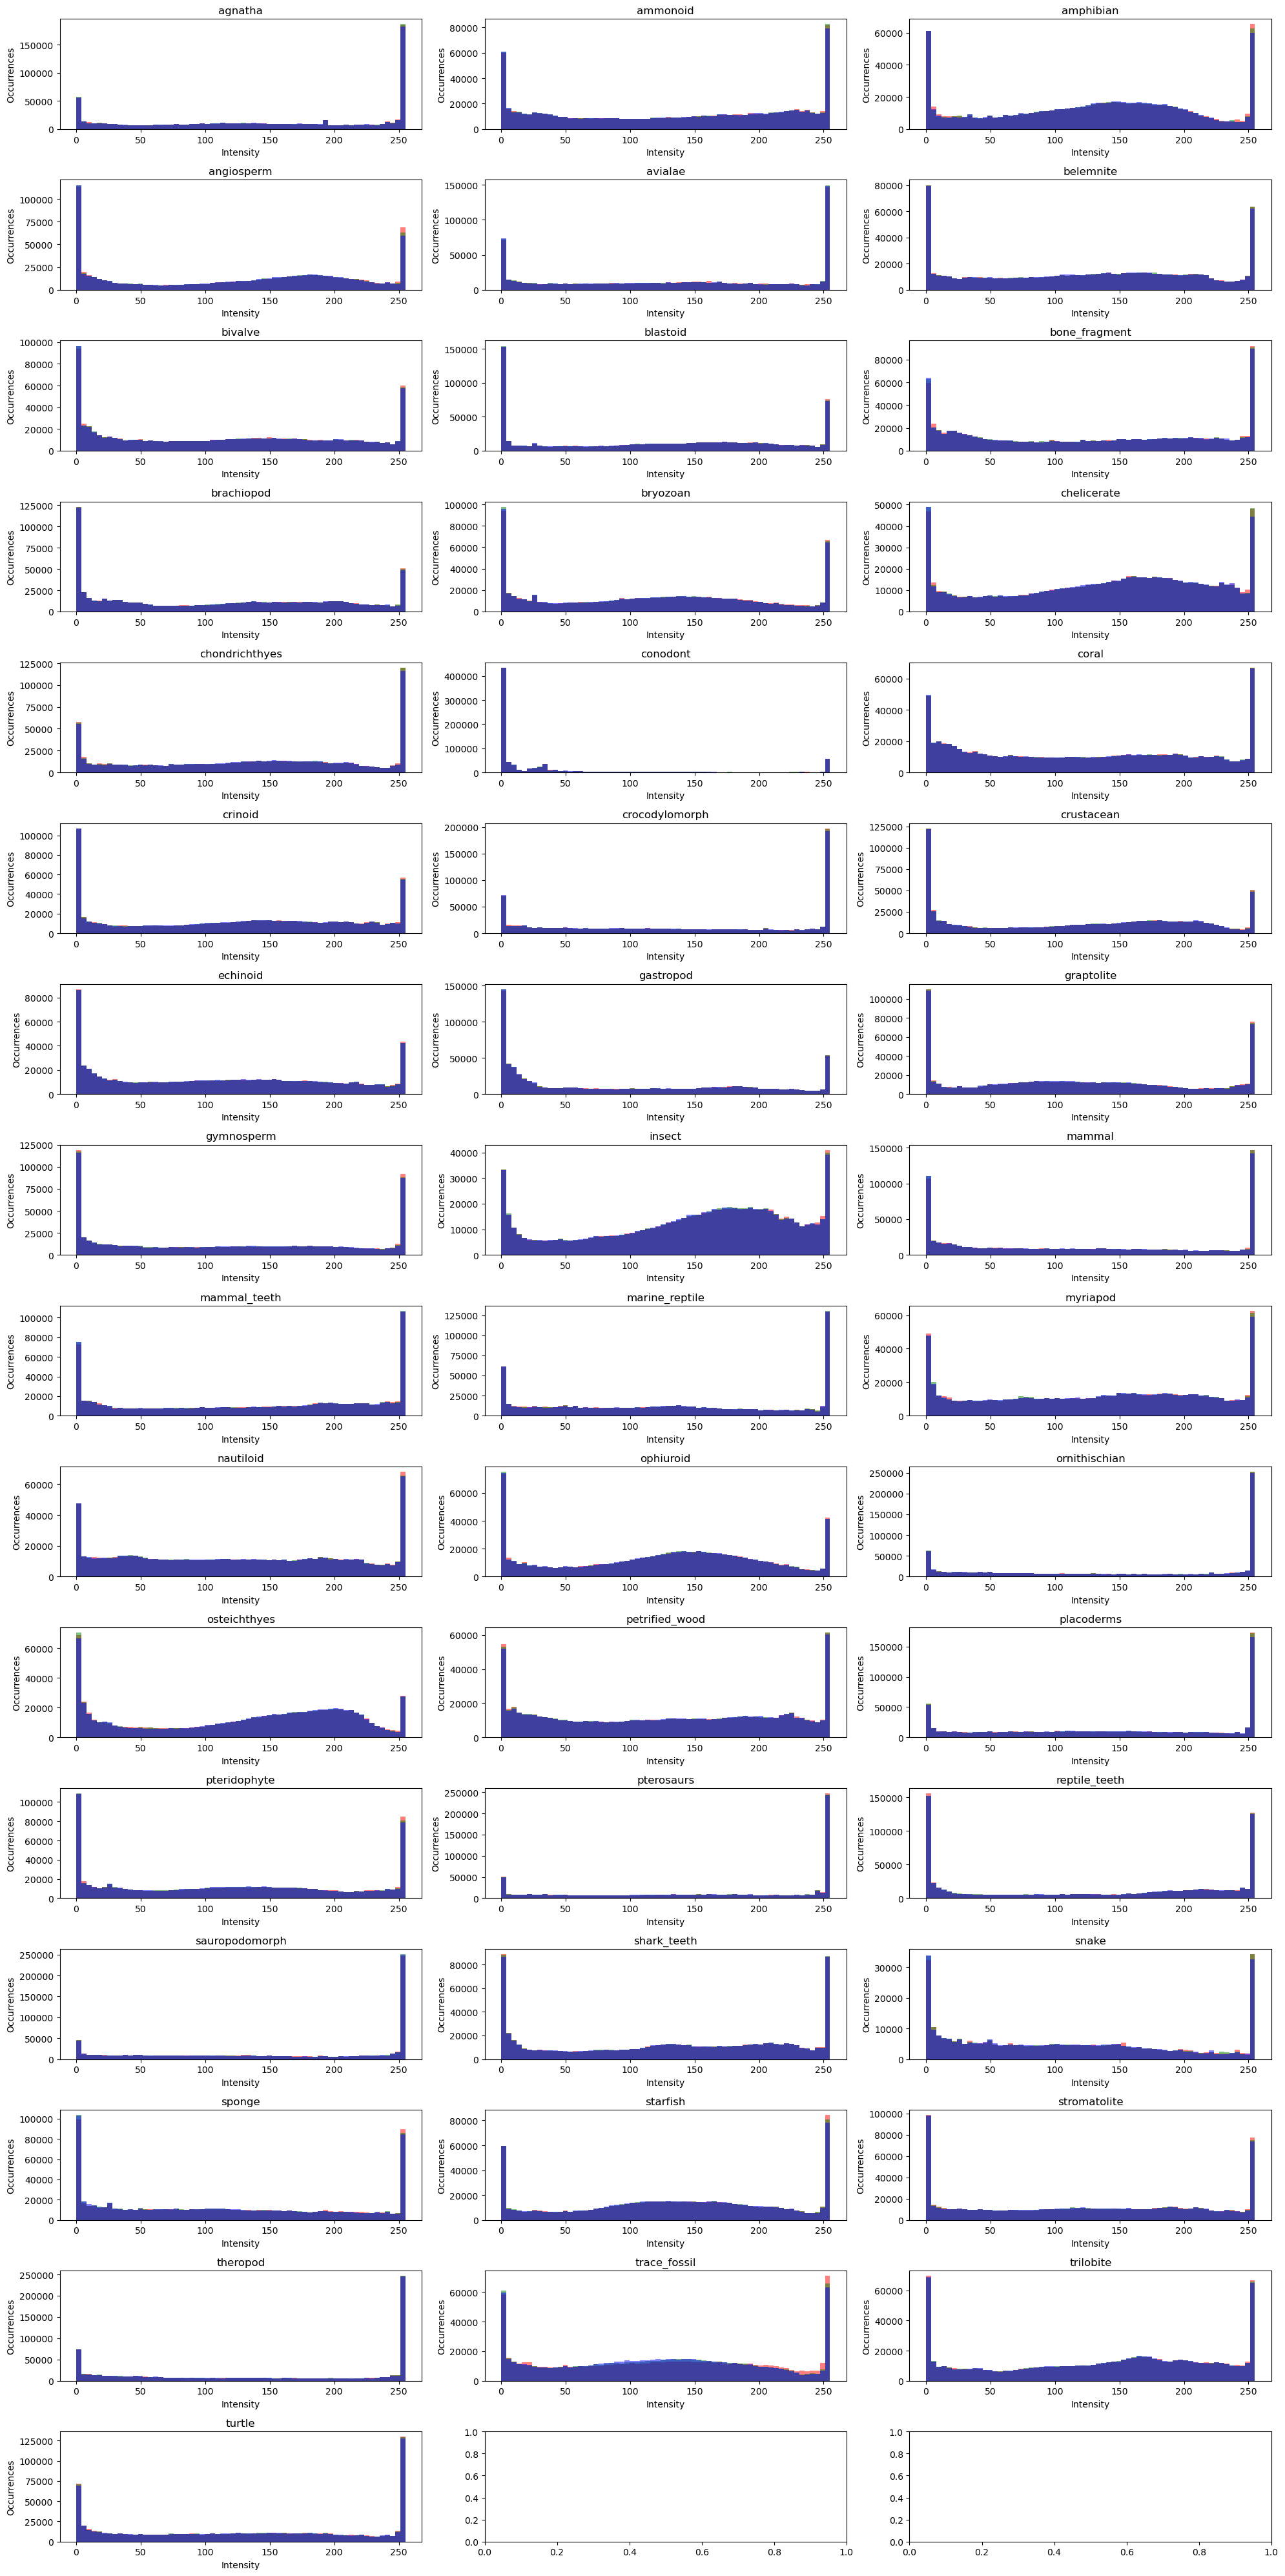

In [34]:
# Compute the number of rows for 3 columns
num_paths = len(img_paths)
num_cols = 3
num_row = num_paths // num_cols
if num_paths % num_cols:
    num_row += 1


# Create subplots for each label
fig, axs = plt.subplots(nrows=num_row, ncols=num_cols, figsize=(20, 40))
axs = axs.flatten()

# Save images of each categorie in a numpy array
for i, file_name in enumerate(img_paths):
    saved_images = []
    paths = img_paths.get(file_name)

    for path in paths:
        # Open image
        with Image.open(path) as img:
            # Resize image
            img = img.resize((224, 224))
            # Save image in numpy array
            img_array = np.array(img)
            # Check if image is of grayscale 
            if img_array.shape == (224, 224):
                print("grayscale image:", path)
                # If grayscale we display it
                display(img)
                continue  # Skip this iteration and move to the next image

            # Save image in a numpy array
            saved_images.append(img_array)

     # combine all images into a single numpy array
    images = np.array(saved_images)

    # Plot histograms for each label
    axs[i].hist(images[:, :, 0].ravel(), bins=64, color='red', alpha=0.5)
    axs[i].hist(images[:, :, 1].ravel(), bins=64, color='green', alpha=0.5)
    axs[i].hist(images[:, :, 2].ravel(), bins=64, color='blue', alpha=0.5)
    axs[i].set(
        title=file_name,
        xlabel="Intensity",
        ylabel="Occurrences",
    )

plt.tight_layout()
plt.show()

It's interesting to observe spikes at the start and at the end. These spikes are caused by the presence of pure black (RGB 0, 0, 0) or pure white (RGB 255, 255, 255).

### Examining if spikes can decrible on of the 46 classes

The goal is to calculate the percentage of black and white pixels in each class. This is done to try to identify a class just by using these pixels.
Here are the steps:
1. load the image 
2. compute the number of black and white pixels by doing the following:
    - Using ``np.all`` function to check whatever it is black [0, 0, 0] pixels or a white [225, 225, 225] pixels. I create a boolean array (e.g. True if blacks). The ``axis=-1`` is used to perform the operation on the color channel.
    - Next, I count the number of ``True`` values using ``np.sum()`` function. This will give me the number of black or white pixels for each image.
    - After, I compute the proportion of black or white pixels and multiplying the result by 100 to get proportion in percentages. 
3. I save all these results in a DataFrame.

In [35]:
import pandas as pd

# Initialise dictionary to save the results
results = {
    "Class": [], 
    "Black Pixels": [], 
    "White Pixels": [], 
}

for file_name in img_paths:
    paths = img_paths.get(file_name)
    
    # Initialise placeholder variables
    total_black = 0
    total_white = 0
    total_pixels = 0

    # Open image and compute the number of black and white pixels
    for path in paths:
        # Load the image
        img = io.imread(path)

        # Compute the ammount of black and white pixels
        total_black += np.sum(np.all(img == [0, 0, 0], axis=-1))
        total_white += np.sum(np.all(img == [225, 225, 225], axis=-1))
        total_pixels += img.size / 3 # size returns total number of elements, so I divide it by 3 to get pixel count


    # Save the results
    results["Class"].append(file_name)
    results["Black Pixels"].append((total_black / total_pixels) * 100) # Computing the proportion of black pixels in percent 
    results["White Pixels"].append((total_white / total_pixels) * 100) # Computing the proportion of white pixels in percent 


# Store all the results in a DataFrame
df = pd.DataFrame(results)
df = df.set_index("Class")
df.head()

In [ ]:
# Show the class date have the higest percentage of black or white pixels
max_black_index = df["Black Pixels"].idxmax() # idxmax return the index of the first occurrence of maximum 
max_white_index = df["White Pixels"].idxmax()
max_black_percent = df.loc[max_black_index, "Black Pixels"].round(2) 
max_white_percent = df.loc[max_white_index, "White Pixels"].round(2)


print(f"Class with the highest percentage of black pixels: {max_black_index} with {max_black_percent}%")
print(f"Class with the highest percentage of white pixels: {max_white_index} with {max_white_percent}%")

Class with the highest percentage of black pixels: conodont with 22.23%
Class with the highest percentage of white pixels: sauropodomorph with 0.17%


In [ ]:
# Show the class date has the lowest percentage of black or white pixels
min_black_index = df["Black Pixels"].idxmin() # idxmin return the index of the first occurrence of minimum 
min_white_index = df["White Pixels"].idxmin()
min_black_percent = df.loc[min_black_index, "Black Pixels"].round(2) 
min_white_percent = df.loc[min_white_index, "White Pixels"].round(2)


print(f"Class with the lowest percentage of black pixels: {min_black_index} with {min_black_percent}%")
print(f"Class with the lowest percentage of white pixels: {min_white_index} with {min_white_percent}%")

Class with the lowest percentage of black pixels: insect with 0.26%
Class with the lowest percentage of white pixels: insect with 0.0%


### Visualise all result in a barh plot

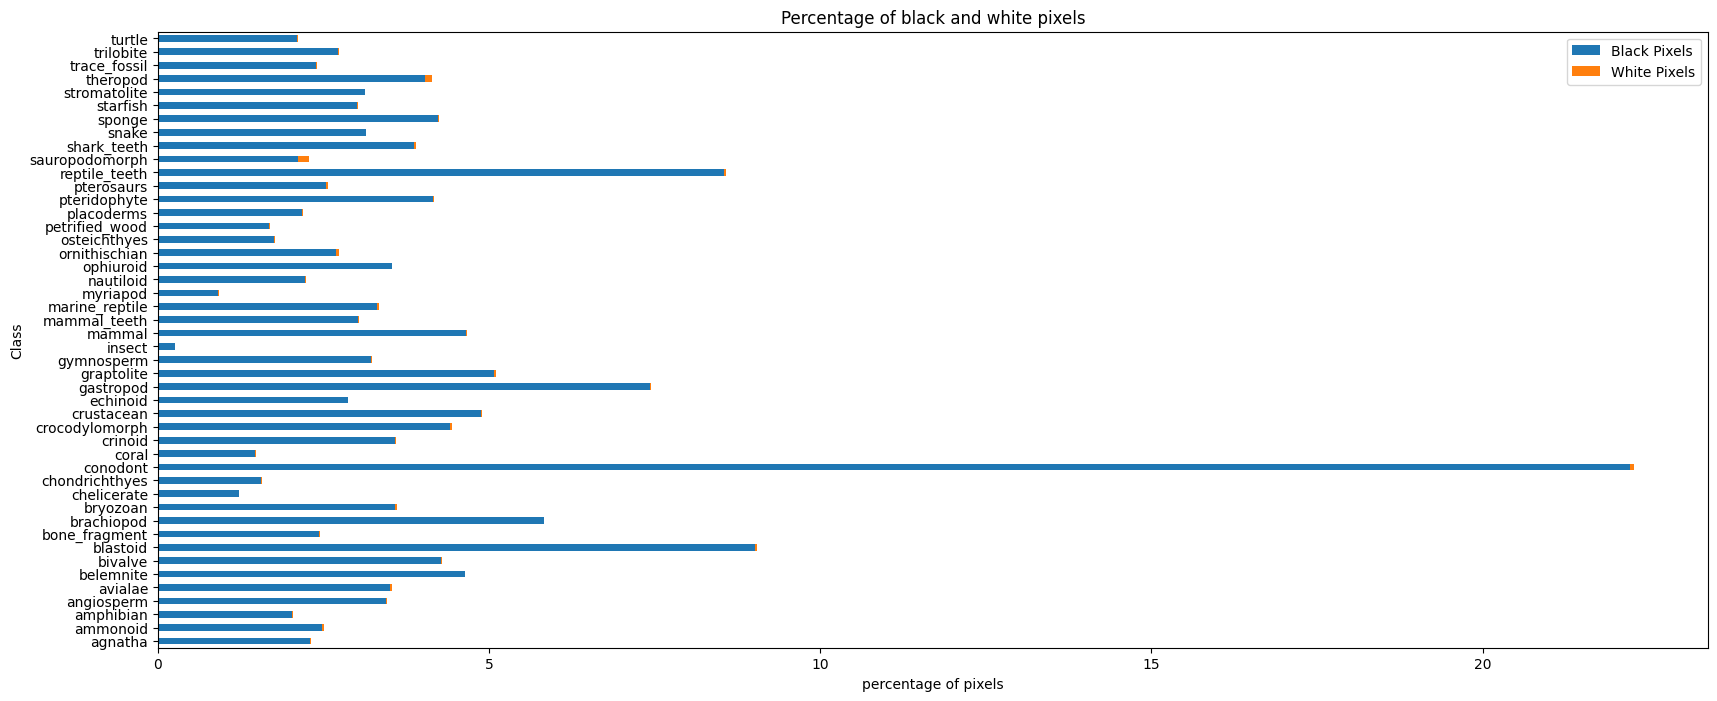

In [ ]:
# Plot the percentage of balck and white pixels
df.plot.barh(stacked=True, figsize=(20, 8))
plt.title("Percentage of black and white pixels")
plt.xlabel("percentage of pixels")
plt.show()

We see that ``conodont`` as the highest percentage of black pixels with more than 20%. I cloud just use these results to classify them, but it might yield loosely results and other classes have some black image in them. So, I can't just use black or white color to classify them.

### Visualizing the average image for each class
The goal is to display the average image of each class. I cloud convert each image to a numpy array of pixels values, summing them and computing the average image. This method produces mathematically exact average, but it requires a lot of memory because it involves creating a numpy array of images for each category.

To solve this issue, I can use the ``blend`` method. This is an alternative way of approximating the average image, it read images one by one blend it into a running average.  This process is more memory-efficient because it only needs to keep two images in memory, the running average and the current image being blended in. 
the definition of PIL blend function is:
    
``out = image1 * (1.0 - alpha) + image2 * alpha``

The ``alpha`` parameter is determining the proportion of the new image to blend in. In my case ``alpha`` will be set to ``1 / (num+1)``. This results in a ratio of ``1/ the image number`` starting with 1/2 for the first image, 1/3 for the second, and so on.  This method doesn't give equal weight to all images as the contribution of each image decreases with each blend operation. Despite this, it can still provide a good approximation of the average image.

Below I will do the two methods to see the difference.

Sources:  
<a href="https://stackoverflow.com/questions/17291455/how-to-get-an-average-picture-from-100-pictures-using-pil">Stack Overflow  post</a>


average_image: Min: 118 Max: 160
bended image Min: 0 Max: 31


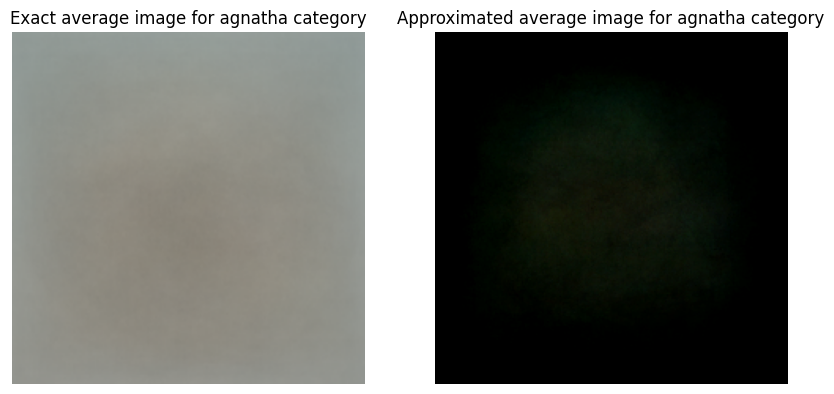

In [ ]:
# Function to load image
def open_image(path):
    with Image.open(path) as img:
        # Resize image
        img = img.resize((224, 224), resample= Image.LANCZOS) 
        return img


# Create subplots for each label
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))


# Method 1
# Create a list to hold the numpy arrays
image_list = []

# For each category find the average image
for i, path in enumerate(img_paths["agnatha"]):
  
    # Method mathematically exact average
    image = np.array(open_image(path), dtype=np.float64)
    image_list.append(image)

# Convert image_list to a numpy array
image_array = np.array(image_list)

# Calculate the exact average
average_image = np.mean(image_array, axis=0)

# Round the float number to integer and change dtype to uint8
average_image = np.round(average_image).astype(np.uint8)

# Display the average image

# Print the minimum and maximum pixel values
print("average_image:", 'Min:', average_image.min(), 'Max:', average_image.max())
ax1.imshow(average_image)
ax1.axis("off")
ax1.set_title(f"Exact average image for agnatha category")


# Method 2
# Using the blend method (approximated average image)
N = len(img_paths["agnatha"])

# initialize 'avg' with the first image
avg_img = open_image(img_paths["agnatha"][0]) 

# Compute the average image using blend        
for num in range(1, N): # Start the loop from 1 to give equal weight to all images
    img = open_image(img_paths["agnatha"][num])

    # Blend image
    avg_img  = Image.blend(avg_img, img, 1 / (num+1))

# Print the minimum and maximum pixel values
avg_img_array = np.array(avg_img)
print("bended image", 'Min:', avg_img_array.min(), 'Max:', avg_img_array.max())

# Display the average image
ax2.imshow(avg_img)
ax2.axis("off")
ax2.set_title(f"Approximated average image for agnatha category")

plt.show() 

The result images are not representing agnatha category. This could be due to the dataset having too much diversity and we can't find a true average image. 

Next, I will use approximated average image method over all the categories.

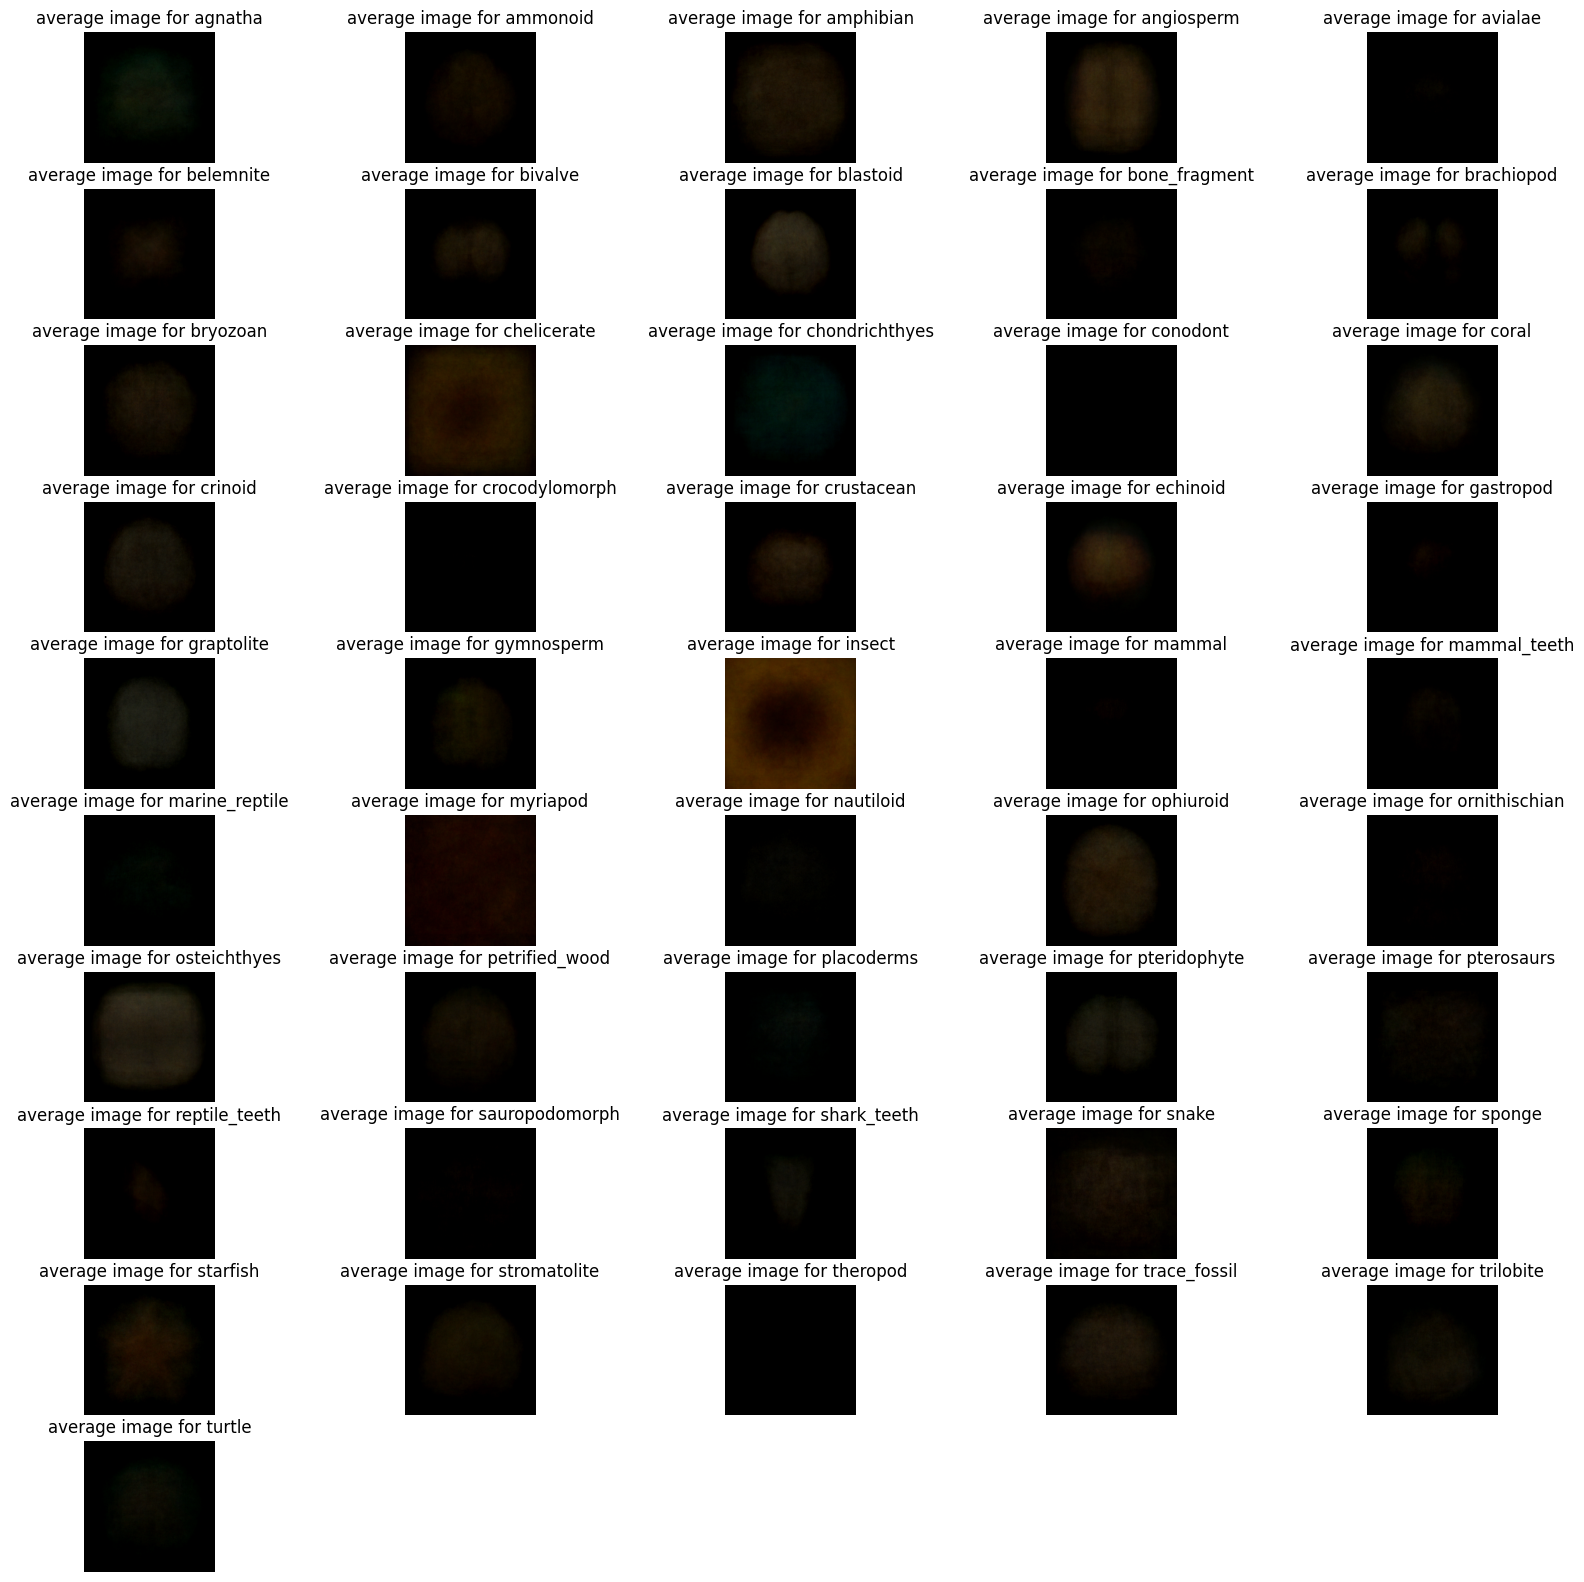

In [ ]:
# Create subplots for each label
fig, axs = plt.subplots(nrows=10, ncols=5, figsize=(20, 20))
ax = axs.flatten()

# For each category find the the average image
for i, file_name in enumerate(img_paths):
  
    paths = img_paths.get(file_name)

    # Number of images
    N = len(paths)

    avg_img = open_image(paths[0]) # initialize 'avg' with the first image
    
    # Compute the average image using blend
    for num in range(1, N):
        img = open_image(paths[num])

        # Blend image
        avg_img  = Image.blend(avg_img, img, 1 / (num+1))


    # Display the average image
    ax[i].imshow(avg_img)
    ax[i].axis("off")
    ax[i].set_title(f"average image for {file_name}")

# Remove the empty subplots
for i in range(len(img_paths), len(ax)):
    fig.delaxes(ax[i])

plt.show() 

All the average images are notably blurry making them indistinguishable. This may be due to the diversity of the images in the dataset and the presence of irrelevant images that hurt the performance and make the capture of a representative average image difficult. I will try again after cleaning and removing all irrelevant images.

## Cleaing  and remove irrelevant images
The most important objective is to better clean my database and remove irrelevant images.
Some images could degrade or hurt the performance of our classifier.


I will do all this setps in the file named: ``Remove-irrelevant-images.ipynb``